 # Grade classification in NLST
 
 Grade dictionary: 
 
1: cannot accessed

2: G1

3: G2

4: G3

5: G4

6: unspecified

8: unknown

9: missing

## Labels: ROI, Normal, other, necrosis

In [1]:
import matplotlib.pyplot as plt
import functools
import numpy as np
import os
import pandas as pd
import random
import re
import skimage
import skimage.io
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.models

import cv2
from segmentation_functions import getMask, chooseRandPixel

In [2]:
CLASSES = {"G1", 
           "G2",
           "G3",
           "G4",
           "other"
          }
N_CLASSES = 5
CLASSES_NAMES = ["G1", "G2", "G3", "G4", "other"]

PATCH_SIZE = 500
DEVICE = "cuda:1"

# 1) Dataset

In [3]:
# Annotated slides
slide_folder = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/"
slide_names = [_ for _ in os.listdir(slide_folder) if _.endswith(".svs")]

mapping_file = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data//NLST_ADC/AACode-Filename-Mapping-curated.csv"
clinical_file = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data//NLST_ADC/nlst_clinical.csv"

mapping_df = pd.read_csv(mapping_file, index_col=0)
clinical_df = pd.read_csv(clinical_file, index_col=0)

In [4]:
# Explore dataset
mapping_df.index = [_.split(" ")[0] for _ in mapping_df.index.values]
mapping_df.index.name = "ID"
clinical_df = clinical_df.merge(mapping_df, left_on = "ID", right_on="ID")
print(np.histogram(clinical_df['Grade'], bins=np.arange(9)+0.5))
clinical_df

(array([ 44, 161, 487, 425,  27,  61,   0,  26]), array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]))


Age  Gender  Tobacco.history  Stage  Grade         filename
ID                                                                  
AA00116   61       2                1      3      3        11445.svs
AA00116   61       2                1      3      3        11446.svs
AA00116   61       2                1      3      3        11447.svs
AA00343   68       1                0      3      3  NLSI0000526.svs
AA00681   65       1                0      3      4         9483.svs
...      ...     ...              ...    ...    ...              ...
AA00228   64       2                0      3      3        10379.svs
AA00228   64       2                0      3      3        10380.svs
AA00037   66       1                1      4      4  NLSI0000234.svs
AA00037   66       1                1      4      4  NLSI0000235.svs
AA00037   66       1                1      4      4  NLSI0000236.svs

[1231 rows x 6 columns]

In [5]:
class Slide:
    def __init__(self, slide_file, pattern="ROI"):
        """Initiate a Slide class.
        
        Args:
            slide_file: Path to slide
            pattern: Labeling in the xml file
            
        Attributes:
            slide_mask, slide_image (on lowest dimension)
            slide: an open_slide object (should be initialized after loading)
            magnitude: 20X or 40X
            level_dims: N*2 array
            slide: open_slide object (None if to save or to load)
        """
        self.slide_file = slide_file
        self.error = 0
        
        slide_found = False
        
        xml_file = re.search(".*(?=svs)", slide_file).group(0) + "xml"
        if not os.path.exists(xml_file):
            print("XML file not found.")
            self.error = 1
            return
        else:
            # Get mask for ROI; x axis of mask is y (rows) of slide image
            if isinstance(pattern, str):
                slide, mask = getMask(xml_file, slide_file, pattern)
                if slide != 0:
                    slide_found = True
            elif isinstance(pattern, list):
                masks = []
                for _pattern in pattern:
                    _slide, mask = getMask(xml_file, slide_file, _pattern)
                    if _slide != 0:
                        slide_found = True
                        slide = _slide
                        masks.append(mask)
                        # print(mask.shape)
                if len(masks):
                    mask = functools.reduce(lambda a, b: np.logical_or(a, b), masks)
                    mask = np.uint8(mask)
             
            if not slide_found:
                # print("No {} found for {}".format(pattern, slide_file))
                self.error = 1
                return
            
            self.slide = slide
            # print('Before cv: ', mask.dtype, np.max(mask))
            self.mask = cv2.erode(mask, np.ones((5, 5)))
            
            if not np.any(self.mask):
                # print("Mask too small")
                self.error = 1
                return
            
            try:
                self.magnitude = self.slide.properties['openslide.objective-power']
            except:
                print("Error find magnitude")
                self.magnitude = "None"
                self.error = 1
                return
            
            if self.magnitude not in ("20", "40"):
                print("Improper magnitude.")
                self.error = 1
                return
                
            try:
                self.level_dims = self.slide.level_dimensions
                self.zoom = self.level_dims[0][0] / self.level_dims[-1][0]
                # self.slide_image = self.slide.read_region((0, 0), len(self.level_dims) - 1, self.level_dims[-1])
                self.slide_id = slide_file.split("/")[-1]
            except:
                print("Error find level dimensions")
                self.error = 1
                
            # self.slide = None  ## Uncomment for saving purpose
            
    @staticmethod
    def get_patch(slide, PATCH_SIZE=512, scale=1):
        """Return an image patch (numpy array) within ROI.
        
        Args:
            PATCH_SIZE: patch size at 40X
            scale: e.g., 0.5 means getting patch from 10X
        """
        x, y = chooseRandPixel(slide.mask)  # x is the columns of original image
        x = int(x * slide.zoom)
        y = int(y * slide.zoom)
        if slide.magnitude == "20":
            patch = slide.slide.read_region((x, y), 0, (int(PATCH_SIZE/2), int(PATCH_SIZE/2)))
        else:
            patch = slide.slide.read_region((x, y), 0, (PATCH_SIZE, PATCH_SIZE))
        patch = np.array(patch)[..., 0:3]
        
        # Resize to 40X
        if slide.magnitude == "20":
            patch = skimage.transform.rescale(patch, 2, preserve_range=True, multichannel=True)
            
        if scale != 1:
            patch = skimage.transform.rescale(patch, scale, preserve_range=True, multichannel=True)
        
        return patch, x, y

In [6]:
from tqdm import tqdm
slides_dict = {}
for slide_name in tqdm(slide_names):
    slide_path = os.path.join(slide_folder, slide_name)
    annotation_path = os.path.join(slide_folder, slide_name[:-3] + 'xml')
    if os.path.exists(annotation_path):
        if slide_name in clinical_df['filename'].values:
            ID = clinical_df.index.values[clinical_df['filename'] == slide_name][0]
            grade = clinical_df.loc[ID, 'Grade']
            if type(grade) != np.int64:
                grade = grade.values[0]
            if grade in np.arange(2, 6):
                slide = Slide(slide_path)
                if slide.error == 0:
                    slide_dict = {}
                    slide_dict['ID'] = ID
                    slide_dict['Grade'] = grade - 2  # 0, 1, 2, 3
                    slide_dict['slide_path'] = slide_path
                    slide_dict['annotation_path'] = annotation_path
                    slide_dict['slide'] = slide
                    slides_dict[slide_name] = slide_dict
            
            slide = Slide(slide_path, ["Normal", "other", "necrosis"])
            if slide.error == 0:
                slide_dict = {}
                slide_dict['ID'] = ID
                slide_dict['slide_path'] = slide_path
                slide_dict['annotation_path'] = annotation_path
                slide_dict['slide'] = slide
                slide_dict['Grade'] = 4  # Other
                slides_dict[slide_name + '_normal'] = slide_dict

100%|██████████| 345/345 [03:40<00:00,  1.56it/s]


In [7]:
slides_dict

{'11042.svs': {'ID': 'AA00477',
  'Grade': 1,
  'slide_path': '/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/11042.svs',
  'annotation_path': '/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/11042.xml',
  'slide': <__main__.Slide at 0x2aade140e668>},
 '11042.svs_normal': {'ID': 'AA00477',
  'slide_path': '/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/11042.svs',
  'annotation_path': '/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/11042.xml',
  'slide': <__main__.Slide at 0x2aade140ee48>,
  'Grade': 4},
 'NLSI0000045.svs': {'ID': 'AA00776',
  'Grade': 1,
  'slide_path': '/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/NLSI0000045.svs',
  'annotation_path': '/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/NLSI0000045.xml',
  'slide': <__main__.Slide at 0x2aade140ed68>},
 'NLSI0000045.svs_normal': {'ID': 'AA00776',
  'slide_

In [38]:
# Split training & validation
indexes_all = list(slides_dict.keys())
indexes_normal = [_ for _ in indexes_all if _.endswith('normal')]
indexes_roi = [_ for _ in indexes_all if _ not in indexes_normal]

np.random.seed(16194)  # 16191
indexes_normal_train = list(np.random.choice(indexes_normal, int(len(indexes_normal) * 0.9), replace=False))
indexes_roi_train = list(np.random.choice(indexes_roi, int(len(indexes_roi) * 0.9), replace=False))
indexes_train = indexes_normal_train + indexes_roi_train
indexes_val = [_ for _ in indexes_all if _ not in indexes_train]
print("# Train {}".format(len(indexes_train)))
print("# val {}".format(len(indexes_val)))
print("# Train normal {}".format(len(indexes_normal_train)))
print("# All normal {}".format(len(indexes_normal)))
print("# Train ROI {}".format(len(indexes_roi_train)))
print("# All ROI {}".format(len(indexes_roi)))

grade = [0, 0, 0, 0, 0]
for _ in indexes_train:
    grade[slides_dict[_]['Grade']] += 1
print("Train: ", grade)
grade = [0, 0, 0, 0, 0]
for _ in indexes_val:
    grade[slides_dict[_]['Grade']] += 1
print("Val: ", grade)

# Train 422
# val 48
# Train normal 145
# All normal 162
# Train ROI 277
# All ROI 308
Train:  [47, 142, 85, 3, 145]
Val:  [3, 16, 11, 1, 17]


In [39]:
indexes_val

['NLSI0000253.svs',
 'NLSI0000078.svs',
 'NLSI0000174.svs',
 '9667.svs_normal',
 '10988.svs',
 'NLSI0000218.svs_normal',
 '11031.svs',
 '11398.svs',
 'NLSI0000157.svs',
 'NLSI0000165.svs_normal',
 '11786.svs_normal',
 '11293.svs',
 '10494.svs',
 'NLSI0000046.svs',
 'NLSI0000290.svs',
 '11345.svs_normal',
 '11262.svs_normal',
 '11185.svs_normal',
 'NLSI0000068.svs',
 '11368.svs',
 '11346.svs_normal',
 'NLSI0000277.svs',
 'NLSI0000198.svs',
 '11463.svs_normal',
 '9683.svs',
 '11247.svs',
 'NLSI0000227.svs',
 'NLSI0000100.svs',
 '11292.svs',
 '10417.svs',
 '11110.svs',
 '11110.svs_normal',
 '10860.svs',
 '11112.svs',
 '9546.svs_normal',
 '11455.svs_normal',
 '11460.svs_normal',
 '10443.svs',
 '10028.svs',
 '11128.svs',
 '9528.svs_normal',
 '9390.svs',
 '9390.svs_normal',
 'NLSI0000104.svs',
 '11033.svs',
 '9777.svs_normal',
 'NLSI0000267.svs',
 'NLSI0000267.svs_normal']

# 2) Data Loader

In [40]:
import math
import skimage
import skimage.transform

def normalize(image, inverse=False):
    if not inverse:
        image = image/255.
    else:
        image = np.clip(image*255, 0, 255).astype(np.uint8)
    return image

def augmentor(image, label=None, stain=None):
    """Do image shape and color augmentation.
    
    Args:
        image: [h, w, c], float
    """
    n_channels = image.shape[2]
    
    if stain is not None:
        stain = stain/255.
    
    # Shape augmentation
    np.random.seed()
    if np.random.uniform(0, 1) < 0.7:
        # Projective transform
        scale = np.random.uniform(0.9, 1.1)
        aspect_ratio = np.random.uniform(0.9, 1.1)
        rotation = np.random.uniform(-0.1, 0.1)
        translationX = np.random.uniform(-10, 10)
        translationY = np.random.uniform(-10, 10)
        g = np.random.uniform(-0.001, 0.001)
        h = np.random.uniform(-0.001, 0.001)

        matrix = np.array([[math.cos(rotation) * scale * aspect_ratio, -math.sin(rotation), translationX],
                          [math.sin(rotation), math.cos(rotation) * scale / aspect_ratio, translationY],
                          [g, h, 1]])
        tform = skimage.transform.ProjectiveTransform(matrix=matrix)
        image_aug = np.zeros_like(image, dtype=np.float)
        for ch in range(n_channels):
            image_aug[..., ch] = skimage.transform.warp(image[..., ch], tform, preserve_range=True)
        
        image = image_aug
        
        if label is not None:
            label_aug = np.zeros_like(label, dtype=np.int)
            label_aug = skimage.transform.warp(label, tform, preserve_range=True, order=0)
            label = label_aug
            
        if stain is not None:
            stain_aug = np.zeros_like(stain, dtype=np.float)
            for ch in range(n_channels):
                stain_aug[..., ch] = skimage.transform.warp(stain[..., ch], tform, preserve_range=True)
            stain = stain_aug
            
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% vertical flipping
        image = image[::-1, :, :]
        
        if label is not None:
            label = label[::-1, :]
            
        if stain is not None:
            stain = stain[::-1, :]
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% horizontal flipping
        image = image[:, ::-1, :]
        
        if label is not None:
            label = label[:, ::-1]
            
        if stain is not None:
            stain = stain[:, ::-1]

    # Color augmentation
    # 1) add a global shifting for all channels
    image = image + np.random.randn(1)[0] * 0.01

    # 2) add a shifting & variance for each channel
    for ch in range(n_channels):
        image[:, :, ch] = image[:, :, ch] * np.clip(np.random.randn(1)[0] * 0.05 + 1, 0.9, 1.1) + np.random.randn(1)[0] * 0.05
        
    return image, label

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, slides_dict, indexes=None, 
                 augmentation=False, crop_size=PATCH_SIZE):
        """
        Args:
            indexes_other: index in image_dict who has "slide_normal"
            indexes: index used for image_dict
        """
        if indexes is None:
            self.indexes = list(slides_dict.keys())
        else:
            self.indexes = indexes
        self.length = len(indexes)
        self.slides_dict = slides_dict
        self.augmentation = augmentation
        self.crop_size = crop_size
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes)
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        Returns:
            idx: indexes of samples (long)
        """
        # Generate data
        image, y = self.__data_generation(self.indexes[index])

        return image, y
    
    def __data_generation(self, index):
        """Generates data containing batch_size samples.
        
        Returns:
            data: a dictionary with data.image in [b, ch, h, w]; data.gene in [b, n_genes]
        """
        image = self.__get_image(index)
        if self.augmentation:
            image, _ = augmentor(normalize(image))
        else:
            image = normalize(image)
        image = torch.tensor(np.transpose(image, (2, 0, 1)).astype(float))
        y = torch.tensor(self.slides_dict[index]['Grade']).long()
        
        return image, y
    
    def __get_image(self, index):
        slide = self.slides_dict[index]['slide']
        patch, _, _ = slide.get_patch(slide, PATCH_SIZE, scale=1)
        return patch

In [41]:
# Generator
train_set = Dataset(slides_dict, indexes=indexes_train, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True, num_workers=1)

val_set = Dataset(slides_dict, indexes=indexes_val, augmentation=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=20, shuffle=False, num_workers=1)

NLSI0000227.svs_normal
tensor(4)


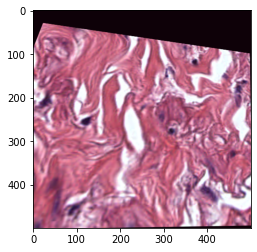

In [44]:
_ = 2
print(indexes_train[_])
image, y = train_set[_]
print(y)
plt.imshow(np.clip(np.transpose((image.numpy() * 255), (1, 2, 0)), 0, 255).astype(np.uint8))
plt.show()

# 3) Create network

In [20]:
import torch
import torch.nn
import torchvision
import torchvision.models

# Self-defined
import networks

class ClassificationModel():
    def __init__(self, n_classes=2,
                 is_train=True, device="0", lr=0.0002, beta1=0.5, save_dir="./models/", n_epochs=100, n_epochs_decay=0):
        self.is_train = is_train
        self.device = device
        self.save_dir = save_dir  # which folder to save models
        self.n_epochs = n_epochs
        self.n_epochs_decay = n_epochs_decay
        
        self.model_names = ['G',]

        # define networks 
        self.netG = torchvision.models.resnet101(pretrained=True)
        self.netG.fc = torch.nn.Linear(self.netG.fc.in_features, n_classes)
        self.netG = self.netG.to(self.device)
        
        if self.is_train:
            # initialize optimizers
            self.optimizers = []
            self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=lr, betas=(beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.schedulers = [networks.get_scheduler(optimizer, lr_policy="linear", 
                                                      n_epochs=n_epochs, 
                                                      n_epochs_decay=n_epochs_decay) for optimizer in self.optimizers]

    def set_input(self, data):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.
        """
        self.images = data[0].float().to(self.device)
        # self.images = color_normalization(self.images).to(self.device)
        self.y = data[1].long().to(self.device)

    def forward(self, val=False):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        if val:
            self.netG.eval()
            self.probs = self.netG(self.images)
        else:
            self.netG.train()
            self.probs = self.netG(self.images)
        
    def backward_G(self, val=False):
        """Calculate the loss for generator G"""

        self.loss_G = torch.nn.CrossEntropyLoss()(self.probs, self.y)
        if not val:
            self.loss_G.backward()
            
    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()
        # G
        self.optimizer_G.zero_grad()
        self.backward_G()           
        self.optimizer_G.step()     
        
    def forward_wo_optimize_parameters(self):
        """Calculate losses in validation set, run within torch.no_grad()"""
        # forward
        self.forward(val=True)
        self.backward_G(val=True)
        
    def save_networks(self, epoch):
        """Save all the networks to the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if isinstance(net, torch.nn.DataParallel):
                    torch.save(net.module.state_dict(), save_path)
                else:
                    torch.save(net.state_dict(), save_path)

    def load_networks(self, epoch):
        """Load all the networks from the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                # for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                #     self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)
    
    def update_learning_rate(self):
        """Update learning rates for all the networks; called at the end of every epoch"""
        old_lr = self.optimizers[0].param_groups[0]['lr']
        for scheduler in self.schedulers:
            scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate %.7f -> %.7f' % (old_lr, lr))

In [49]:
model_dir = "./models/1_grade_classification_in_NLST"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
classification_model = ClassificationModel(device=DEVICE, save_dir=model_dir, n_epochs=100, lr=0.00005, 
                                          n_classes=N_CLASSES)

## Train

In [125]:
def get_item(x):
    if x.__class__ == torch.Tensor:
        return x.item()
    else:
        return x

def train(model, train_loader, epoch, loss_names, print_freq=30):
    print("Train epoch {}".format(epoch))
    hist = dict()
    for loss_name in loss_names:
        hist[loss_name] = []
    
    for i, data in enumerate(train_loader):
        # Forward and backward
        model.set_input(data)
        model.optimize_parameters()
        
        YS.extend(list(data[1].numpy()))
        PREDS.extend(list(torch.argmax(model.probs, 1).cpu().numpy()))
        
        # Update hist
        try:
            for loss_name in loss_names:
                loss = getattr(model, loss_name)
                if isinstance(loss, dict):
                    for key in list(loss.keys()):
                        loss[key] = get_item(loss[key])
                    if hist[loss_name] == []:
                        hist[loss_name] = dict()
                        for key in list(loss.keys()):
                            hist[loss_name][key] = []
                    for key in list(loss.keys()):
                        hist[loss_name][key].append(loss[key])
                else:
                    hist[loss_name].append(get_item(loss))
        except:
            print(loss_name)
            raise
        
        if (i + 1) % print_freq == 0:
            to_print = ""
            for loss_name in loss_names:
                if isinstance(hist[loss_name], dict):
                    for key in list(hist[loss_name].keys()):
                        to_print += loss_name + "_" + key + " " + str(np.round(np.average(hist[loss_name][key]), 3))
                        to_print += "\t"
                else:
                    to_print += loss_name + " " + str(np.round(np.average(hist[loss_name]), 3))
                    to_print += "\t"
            print(to_print)
    
    for loss_name in loss_names:
        if isinstance(hist[loss_name], dict):
            for key in list(hist[loss_name].keys()):
                hist[loss_name][key] = np.average(hist[loss_name][key])
        else:
            hist[loss_name] = np.average(hist[loss_name])
                
    return hist

def val(model, val_loader, epoch, loss_names, n_patches=2):
    print("Val epoch {}".format(epoch))
    hist = dict()
    for loss_name in loss_names:
        hist[loss_name] = []
    
    ys = []
    preds = []
    
    for n_patch in range(n_patches):
        for i, data in enumerate(val_loader):
            with torch.no_grad():
                # Forward
                model.set_input(data)
                model.forward_wo_optimize_parameters()

            ys.extend(list(data[1].numpy()))
            preds.extend(list(torch.argmax(model.probs, 1).cpu().numpy()))

            # Update hist
            for loss_name in loss_names:
                loss = getattr(model, loss_name)
                if isinstance(loss, dict):
                    for key in list(loss.keys()):
                        loss[key] = get_item(loss[key])
                    if hist[loss_name] == []:
                        hist[loss_name] = dict()
                        for key in list(loss.keys()):
                            hist[loss_name][key] = []
                    for key in list(loss.keys()):
                        hist[loss_name][key].append(loss[key])
                else:
                    hist[loss_name].append(get_item(loss))
    
    to_print = ""
    for loss_name in loss_names:
        if isinstance(hist[loss_name], dict):
            for key in list(hist[loss_name].keys()):
                hist[loss_name][key] = np.average(hist[loss_name][key])
                to_print += loss_name + "_" + key + " " + str(np.round(hist[loss_name][key], 3))
                to_print += "\t"
        else:
            hist[loss_name] = np.average(hist[loss_name])
            to_print += loss_name + " " + str(np.round(hist[loss_name], 3))
            to_print += "\t"
    print(to_print)
    print("Accuracy: ", np.sum(np.array(ys) == np.array(preds))/len(ys))
    
    from sklearn.metrics import confusion_matrix
    plt.figure(figsize=(5, 5))
    plot_confusion_matrix_combine(confusion_matrix(ys, preds), CLASSES_NAMES,
                                 stain_norm=True, cmap=plt.cm.hot_r)
                
    return hist

In [51]:
# History
loss_names = ["loss_G"]
hist = dict()
for loss_name in loss_names:
    hist[loss_name] = []
    hist[loss_name+"_val"] = []

In [52]:
import time

save_freq = 5
best_loss_val = 10000

for epoch in range(0, classification_model.n_epochs + classification_model.n_epochs_decay): 
    epoch_start_time = time.time()
    
    global YS
    global PREDS
    YS = []
    PREDS = []
    hist_epoch = train(classification_model, train_loader, epoch, loss_names, print_freq=2)
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name] == []:
                hist[loss_name] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name].append(hist_epoch[loss_name])
    from sklearn.metrics import confusion_matrix
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix_combine(confusion_matrix(YS, PREDS), CLASSES_NAMES,
                                 stain_norm=True, cmap=plt.cm.hot_r)
    
    hist_epoch = val(classification_model, val_loader, epoch, loss_names)
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name+"_val"] == []:
                hist[loss_name+"_val"] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name+"_val"][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name+"_val"][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name+"_val"].append(hist_epoch[loss_name])
    
    # Save model
    if epoch % save_freq == 0:
        classification_model.save_networks(epoch)
        print("Saved model to {}".format(os.path.join(model_dir, str(epoch)+"_..._.pt")))
    if hist["loss_G_val"][-1] < best_loss_val:
        classification_model.save_networks("best")
        print("Saved best model to {}".format(os.path.join(model_dir, "best_..._.pt")))
        best_loss_val = hist["loss_G_val"][-1]
        
    classification_model.update_learning_rate()

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, classification_model.n_epochs + classification_model.n_epochs_decay, time.time() - epoch_start_time))

Train epoch 0
loss_G 1.746	
loss_G 1.67	
loss_G 1.595	
loss_G 1.557	
loss_G 1.551	
loss_G 1.521	
loss_G 1.497	
loss_G 1.473	
loss_G 1.433	
loss_G 1.408	
loss_G 1.434	
Val epoch 0
loss_G 1.226	
Accuracy:  0.4791666666666667
Saved model to ./models/1_grade_classification_in_NLST/0_..._.pt
Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
learning rate 0.0000500 -> 0.0000500
End of epoch 0 / 100 	 Time Taken: 131 sec
Train epoch 1
loss_G 1.349	
loss_G 1.336	
loss_G 1.259	
loss_G 1.233	
loss_G 1.202	
loss_G 1.199	
loss_G 1.171	
loss_G 1.177	
loss_G 1.176	
loss_G 1.177	
loss_G 1.155	
Val epoch 1
loss_G 0.996	
Accuracy:  0.5729166666666666
Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
learning rate 0.0000500 -> 0.0000500
End of epoch 1 / 100 	 Time Taken: 133 sec
Train epoch 2
loss_G 1.268	
loss_G 1.191	
loss_G 1.12	
loss_G 1.087	
loss_G 1.109	
loss_G 1.137	
loss_G 1.117	
loss_G 1.131	
loss_G 1.124	
loss_G 1.104	
loss_G 1.131	
Val epoch 2
los

loss_G 0.906	
loss_G 1.031	
loss_G 0.955	
loss_G 0.941	
loss_G 0.977	
loss_G 0.985	
loss_G 0.985	
loss_G 0.962	
loss_G 0.941	
loss_G 0.939	
loss_G 1.026	
Val epoch 25
loss_G 1.215	
Accuracy:  0.4791666666666667
Saved model to ./models/1_grade_classification_in_NLST/25_..._.pt
learning rate 0.0000500 -> 0.0000500
End of epoch 25 / 100 	 Time Taken: 135 sec
Train epoch 26
loss_G 0.967	
loss_G 0.929	
loss_G 0.898	
loss_G 0.907	
loss_G 0.885	
loss_G 0.881	
loss_G 0.896	
loss_G 0.89	
loss_G 0.896	
loss_G 0.893	
loss_G 0.92	
Val epoch 26
loss_G 0.886	
Accuracy:  0.5833333333333334
learning rate 0.0000500 -> 0.0000500
End of epoch 26 / 100 	 Time Taken: 138 sec
Train epoch 27
loss_G 0.987	
loss_G 0.962	
loss_G 0.945	
loss_G 0.964	
loss_G 0.933	
loss_G 0.883	
loss_G 0.877	
loss_G 0.902	
loss_G 0.891	
loss_G 0.897	
loss_G 0.932	
Val epoch 27
loss_G 0.994	
Accuracy:  0.59375
learning rate 0.0000500 -> 0.0000500
End of epoch 27 / 100 	 Time Taken: 143 sec
Train epoch 28
loss_G 0.732	
loss_G 0.899

loss_G 0.859	
loss_G 0.842	
loss_G 0.824	
loss_G 0.793	
loss_G 0.795	
loss_G 0.771	
loss_G 0.778	
loss_G 0.768	
loss_G 0.791	
loss_G 0.812	
loss_G 0.803	
Val epoch 51
loss_G 1.199	
Accuracy:  0.5833333333333334
learning rate 0.0000500 -> 0.0000500
End of epoch 51 / 100 	 Time Taken: 135 sec
Train epoch 52
loss_G 0.947	
loss_G 0.872	
loss_G 0.822	
loss_G 0.873	
loss_G 0.822	
loss_G 0.789	
loss_G 0.785	
loss_G 0.802	
loss_G 0.791	
loss_G 0.801	
loss_G 0.798	
Val epoch 52
loss_G 1.001	
Accuracy:  0.6145833333333334
learning rate 0.0000500 -> 0.0000500
End of epoch 52 / 100 	 Time Taken: 131 sec
Train epoch 53
loss_G 1.011	
loss_G 0.806	
loss_G 0.82	
loss_G 0.852	
loss_G 0.835	
loss_G 0.847	
loss_G 0.813	
loss_G 0.795	
loss_G 0.825	
loss_G 0.813	
loss_G 0.847	
Val epoch 53
loss_G 1.024	
Accuracy:  0.5416666666666666
learning rate 0.0000500 -> 0.0000500
End of epoch 53 / 100 	 Time Taken: 139 sec
Train epoch 54
loss_G 0.956	
loss_G 0.88	
loss_G 0.897	
loss_G 0.911	
loss_G 0.865	
loss_G 0.90

KeyboardInterrupt: 

In [53]:
classification_model.save_networks(epoch)
print("Saved model to {}".format(os.path.join(model_dir, str(epoch)+"_..._.pt")))
torch.save(hist, os.path.join(model_dir, "hist.pt"))

Saved model to ./models/1_grade_classification_in_NLST/74_..._.pt


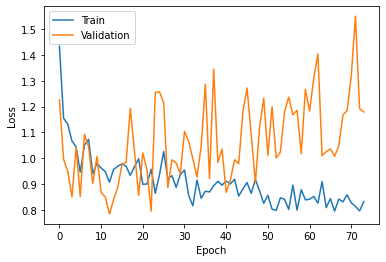

In [54]:
plt.plot(hist['loss_G'], label="Train")
plt.plot(hist['loss_G_val'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# 3) Extract patches for testing set

In [56]:
n_to_extract = 30
for index in tqdm(indexes_val):
    slide = slides_dict[index]['slide']
    n_extracted = len([_ for _ in os.listdir("./data/val_patches") 
                          if re.search('{}.*{}\.png'.format(index, slides_dict[index]['Grade']), _) is not None])
    # print(n_extracted)
    for _ in range(max(n_to_extract - n_extracted, 0)):
        n_extracted = len([_ for _ in os.listdir("./data/val_patches") 
                          if re.search('{}.*{}\.png'.format(index, slides_dict[index]['Grade']), _) is not None])
        
        
        patch, x, y = slide.get_patch(slide, PATCH_SIZE, scale=1)
        patch = np.array(patch, dtype=np.uint8)
        skimage.io.imsave(os.path.join("./data/val_patches", 
                                       "{}_{}_{}_grade_{}.png".format(index, x, y, slides_dict[index]['Grade'])), 
                         patch)
        # plt.imshow(patch)
        # plt.show()
        # break
    # break

 31%|███▏      | 15/48 [01:45<03:53,  7.09s/it]/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./data/val_patches/11345.svs_normal_74925_38758_grade_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./data/val_patches/11345.svs_normal_61354_48424_grade_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./data/val_patches/11345.svs_normal_81390_56265_grade_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./data/val_patches/11345.svs_normal_65291_40839_grade_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home2/swan15/.conda/envs/mas

In [57]:
slides_dict[indexes_val[0]]

{'ID': 'AA00044',
 'Grade': 1,
 'slide_path': '/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/NLSI0000253.svs',
 'annotation_path': '/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC/NLSI0000253.xml',
 'slide': <__main__.Slide at 0x2aade140e550>}

# 4) Test in testing set

In [58]:
hist = torch.load(os.path.join(model_dir, "hist.pt"))
np.argmin(hist['loss_G_val'])

12

In [59]:
epoch = 'best'
# 40: 53%
# 45: 59%
# 50: 56%
# 5: 53%
# 95: 60%
# 99: 58%
classification_model.load_networks(epoch)

loading the model from ./models/1_grade_classification_in_NLST/best_net_G.pth


In [60]:
val_patch_names = [_ for  _ in os.listdir("./data/val_patches/") if _.endswith(".png")]
print("Val epoch {}".format(epoch))
data_val = []
ys = []
preds = []
for val_patch_name in val_patch_names:
    val_patch = skimage.io.imread(os.path.join("./data/val_patches", val_patch_name))
    val_patch = normalize(val_patch)
    val_patch = torch.tensor(np.transpose(val_patch, (2, 0, 1)).astype(float))
    val_patch = val_patch.unsqueeze(0)
    y = torch.tensor(int(val_patch_name.split('.png')[0].split('_')[-1])).unsqueeze(0)
    data = [val_patch, y]
    with torch.no_grad():
        # Forward
        classification_model.set_input(data)
        classification_model.forward_wo_optimize_parameters()
    
    data_val.append(data)
    ys.extend(list(data[1].numpy()))
    preds.extend(list(torch.argmax(classification_model.probs, 1).cpu().numpy()))
print("Accuracy: ", np.sum(np.array(ys) == np.array(preds))/len(ys))

Val epoch best
Accuracy:  0.6430555555555556


In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ys, preds)
cm

array([[ 29,  46,   7,   0,   8],
       [ 14, 344,  62,   0,  60],
       [  5, 200,  75,   0,  50],
       [  0,  12,   7,   0,  11],
       [ 20,  10,   2,   0, 478]])

In [62]:
import itertools
def plot_confusion_matrix_combine(cm, classes,
                                  title='Confusion matrix',
                                  cmap=plt.cm.Blues, stain_norm=False):
    """
    This function prints and plots the confusion matrix with numbers and accuracy together.
    """
    print("Accuracy: {}".format(np.trace(cm)/np.sum(cm)))
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Remove nan
    cm_norm[np.isnan(cm_norm)] = 0
    
    if not stain_norm:
        thresh = cm.max() / 2.
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        thresh = cm_norm.max() / 2.
        plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    # fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if not stain_norm:
            plt.text(j, i+0.2, "{} \n{}%".format(format(cm[i, j], 'd'), format(cm_norm[i, j]*100, '.0f')),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i+0.2, "{} \n{}%".format(format(cm[i, j], 'd'), format(cm_norm[i, j]*100, '.0f')),
                     horizontalalignment="center",
                     color="white" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy: 0.6430555555555556


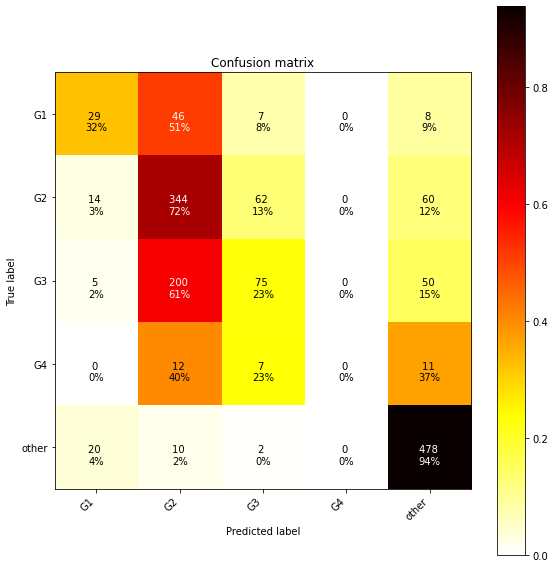

In [63]:
plt.figure(figsize=(8, 8))
plot_confusion_matrix_combine(confusion_matrix(ys, preds), CLASSES_NAMES,
                             stain_norm=True, cmap=plt.cm.hot_r)

# 5) Add weight and continue to train from epoch best

In [153]:
class ClassificationModelWeighted(ClassificationModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def set_loss_weight(self, weight):
        self.weight = weight.to(self.device)
        
    def backward_G(self, val=False):
        """Calculate the loss for generator G"""

        self.loss_G = torch.nn.CrossEntropyLoss(weight=self.weight)(self.probs, self.y)
        if not val:
            self.loss_G.backward()

In [154]:
# [40, 129, 75, 3, 46]
device_2 = "cuda:1"
classification_model_weight = ClassificationModelWeighted(device=device_2, save_dir=model_dir, 
                                                          n_epochs=100, lr=0.00001, 
                                          n_classes=N_CLASSES)
weight = torch.tensor([3, 0.5, 0.9, 10, 1])
classification_model_weight.set_loss_weight(weight=weight)

In [155]:
classification_model_weight.load_networks('best')
hist = torch.load(os.path.join(model_dir, "hist.pt"))

loading the model from ./models/1_grade_classification_in_NLST/best_net_G.pth


Train epoch 100
loss_G 1.086	
loss_G 1.374	
loss_G 1.639	
loss_G 1.438	
loss_G 1.318	
loss_G 1.273	
loss_G 1.233	
loss_G 1.21	
loss_G 1.265	
loss_G 1.233	
loss_G 1.198	
Accuracy: 0.6018957345971564


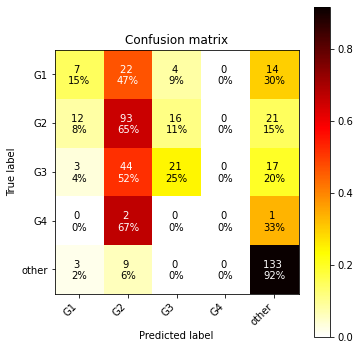

Val epoch 100
loss_G 1.291	
Accuracy:  0.65625
Accuracy: 0.65625


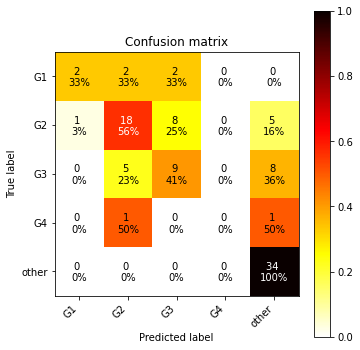

Saved model to ./models/1_grade_classification_in_NLST/100_..._.pt
Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 100 / 100 	 Time Taken: 140 sec
Train epoch 101
loss_G 0.842	
loss_G 0.811	
loss_G 1.014	
loss_G 0.97	
loss_G 0.953	
loss_G 0.972	
loss_G 1.007	
loss_G 0.996	
loss_G 0.983	
loss_G 0.996	
loss_G 1.075	
Accuracy: 0.6184834123222749


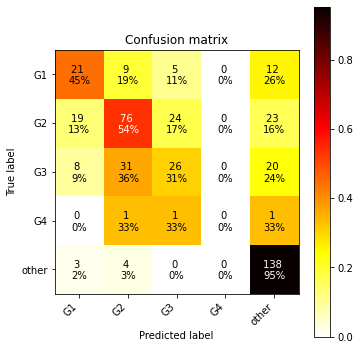

Val epoch 101
loss_G 1.261	
Accuracy:  0.5729166666666666
Accuracy: 0.5729166666666666


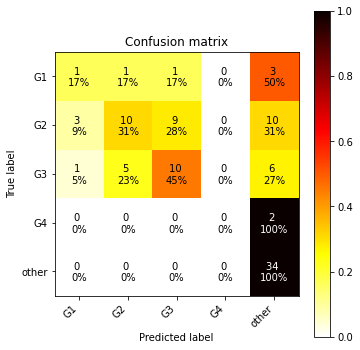

Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 101 / 100 	 Time Taken: 137 sec
Train epoch 102
loss_G 1.281	
loss_G 1.339	
loss_G 1.14	
loss_G 1.153	
loss_G 1.107	
loss_G 1.059	
loss_G 1.098	
loss_G 1.095	
loss_G 1.072	
loss_G 1.07	
loss_G 1.038	
Accuracy: 0.5829383886255924


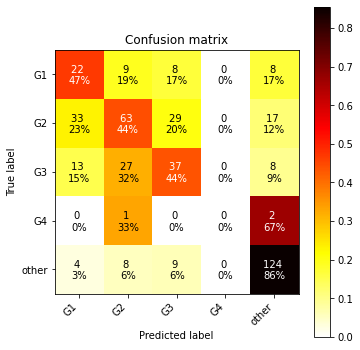

Val epoch 102
loss_G 1.204	
Accuracy:  0.6354166666666666
Accuracy: 0.6354166666666666


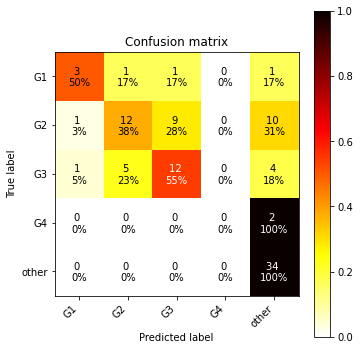

Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 102 / 100 	 Time Taken: 132 sec
Train epoch 103
loss_G 0.626	
loss_G 0.81	
loss_G 0.969	
loss_G 1.074	
loss_G 1.05	
loss_G 1.014	
loss_G 1.041	
loss_G 1.028	
loss_G 1.043	
loss_G 1.027	
loss_G 1.027	
Accuracy: 0.5710900473933649


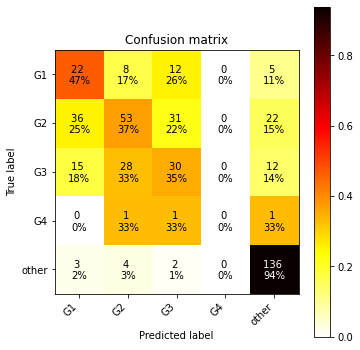

Val epoch 103
loss_G 1.357	
Accuracy:  0.5416666666666666
Accuracy: 0.5416666666666666


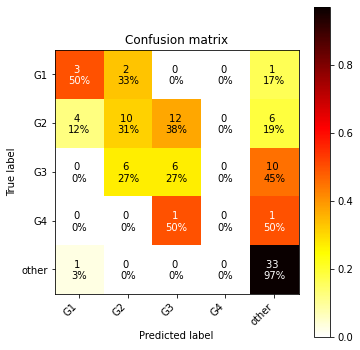

End of epoch 103 / 100 	 Time Taken: 134 sec
Train epoch 104
loss_G 1.008	
loss_G 0.883	
loss_G 0.88	
loss_G 0.919	
loss_G 0.945	
loss_G 0.963	
loss_G 0.954	
loss_G 0.937	
loss_G 0.962	
loss_G 0.967	
loss_G 0.984	
Accuracy: 0.5545023696682464


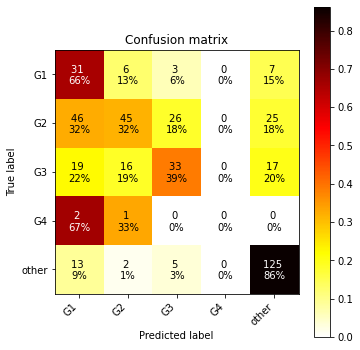

Val epoch 104
loss_G 1.229	
Accuracy:  0.5729166666666666
Accuracy: 0.5729166666666666


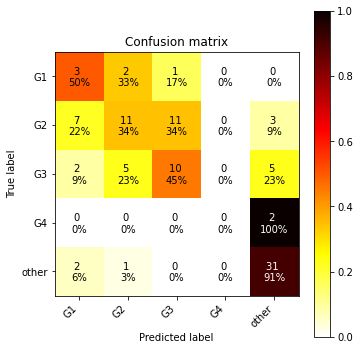

End of epoch 104 / 100 	 Time Taken: 134 sec
Train epoch 105
loss_G 1.239	
loss_G 1.008	
loss_G 0.921	
loss_G 0.896	
loss_G 0.886	
loss_G 0.917	
loss_G 0.932	
loss_G 0.923	
loss_G 0.922	
loss_G 0.901	
loss_G 0.923	
Accuracy: 0.5781990521327014


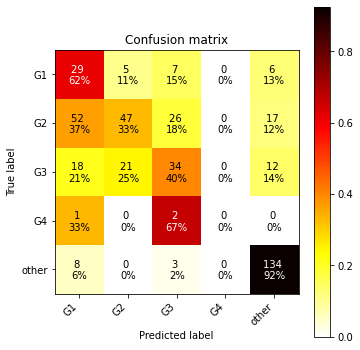

Val epoch 105
loss_G 1.092	
Accuracy:  0.53125
Accuracy: 0.53125


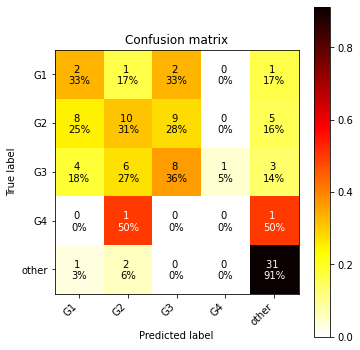

Saved model to ./models/1_grade_classification_in_NLST/105_..._.pt
Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 105 / 100 	 Time Taken: 136 sec
Train epoch 106
loss_G 1.762	
loss_G 1.349	
loss_G 1.241	
loss_G 1.183	
loss_G 1.185	
loss_G 1.125	
loss_G 1.09	
loss_G 1.069	
loss_G 1.036	
loss_G 1.007	
loss_G 1.013	
Accuracy: 0.5710900473933649


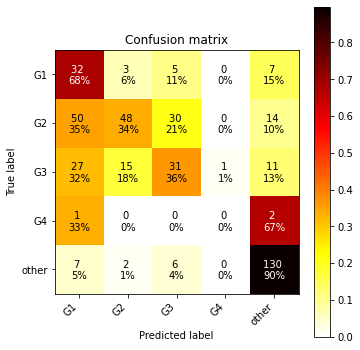

Val epoch 106
loss_G 1.095	
Accuracy:  0.5729166666666666
Accuracy: 0.5729166666666666


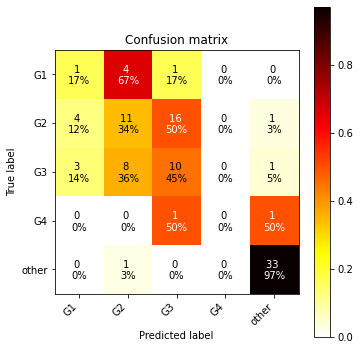

End of epoch 106 / 100 	 Time Taken: 130 sec
Train epoch 107
loss_G 0.915	
loss_G 0.858	
loss_G 0.888	
loss_G 0.904	
loss_G 0.981	
loss_G 0.929	
loss_G 0.913	
loss_G 0.933	
loss_G 0.918	
loss_G 0.925	
loss_G 0.942	
Accuracy: 0.5402843601895735


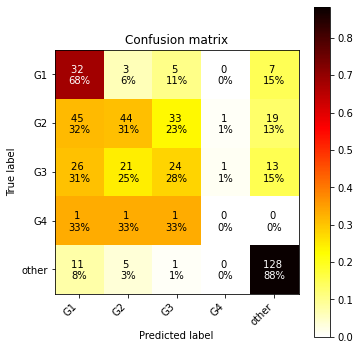

Val epoch 107
loss_G 1.076	
Accuracy:  0.59375
Accuracy: 0.59375


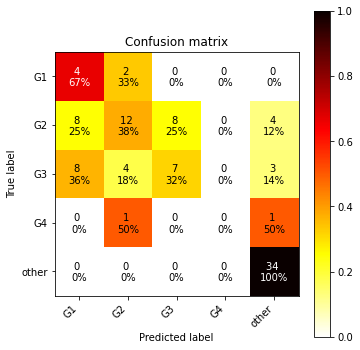

Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 107 / 100 	 Time Taken: 133 sec
Train epoch 108
loss_G 1.0	
loss_G 0.967	
loss_G 0.961	
loss_G 0.904	
loss_G 0.939	
loss_G 0.911	
loss_G 0.897	
loss_G 0.906	
loss_G 0.896	
loss_G 0.906	
loss_G 0.886	
Accuracy: 0.5639810426540285


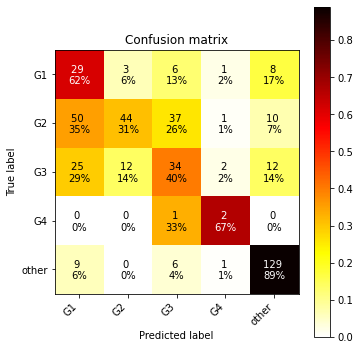

Val epoch 108
loss_G 1.067	
Accuracy:  0.5104166666666666
Accuracy: 0.5104166666666666


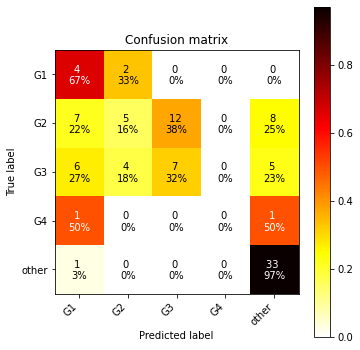

Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 108 / 100 	 Time Taken: 137 sec
Train epoch 109
loss_G 0.994	
loss_G 0.88	
loss_G 0.842	
loss_G 0.782	
loss_G 0.879	
loss_G 0.881	
loss_G 0.893	
loss_G 0.882	
loss_G 0.898	
loss_G 0.88	
loss_G 0.87	
Accuracy: 0.5687203791469194


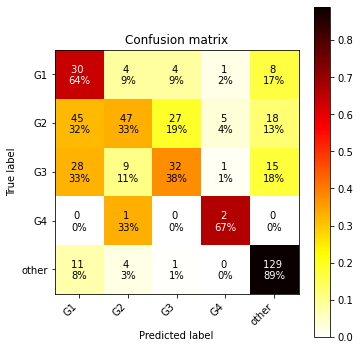

Val epoch 109
loss_G 1.142	
Accuracy:  0.6041666666666666
Accuracy: 0.6041666666666666


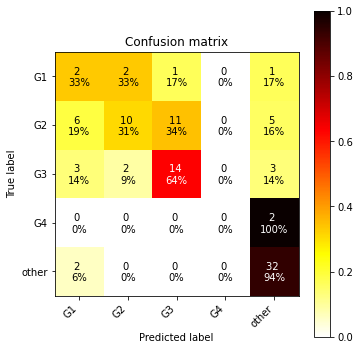

End of epoch 109 / 100 	 Time Taken: 132 sec
Train epoch 110
loss_G 0.628	
loss_G 0.765	
loss_G 0.806	
loss_G 0.811	
loss_G 0.875	
loss_G 0.88	
loss_G 0.871	
loss_G 0.872	
loss_G 0.854	
loss_G 0.853	
loss_G 0.883	
Accuracy: 0.6137440758293838


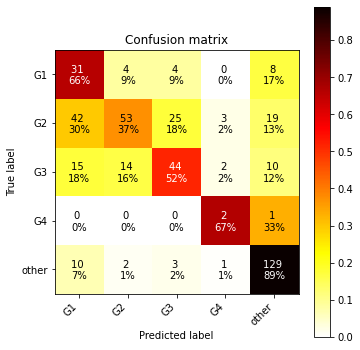

Val epoch 110
loss_G 1.04	
Accuracy:  0.53125
Accuracy: 0.53125


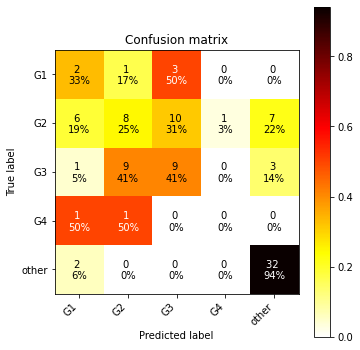

Saved model to ./models/1_grade_classification_in_NLST/110_..._.pt
Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 110 / 100 	 Time Taken: 136 sec
Train epoch 111
loss_G 0.845	
loss_G 1.047	
loss_G 1.186	
loss_G 1.114	
loss_G 1.072	
loss_G 1.064	
loss_G 1.043	
loss_G 1.037	
loss_G 1.019	
loss_G 1.013	
loss_G 1.032	
Accuracy: 0.5379146919431279


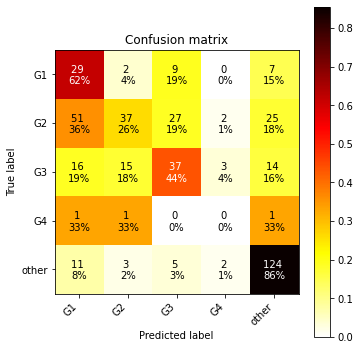

Val epoch 111
loss_G 1.287	
Accuracy:  0.6041666666666666
Accuracy: 0.6041666666666666


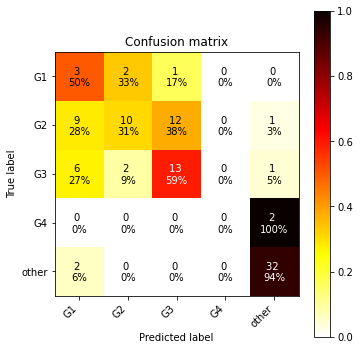

End of epoch 111 / 100 	 Time Taken: 146 sec
Train epoch 112
loss_G 0.986	
loss_G 0.917	
loss_G 0.941	
loss_G 0.903	
loss_G 0.943	
loss_G 0.949	
loss_G 0.97	
loss_G 0.934	
loss_G 0.922	
loss_G 0.911	
loss_G 0.924	
Accuracy: 0.5829383886255924


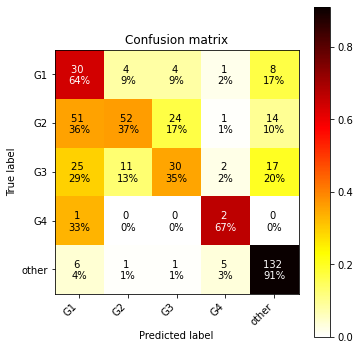

Val epoch 112
loss_G 1.05	
Accuracy:  0.5833333333333334
Accuracy: 0.5833333333333334


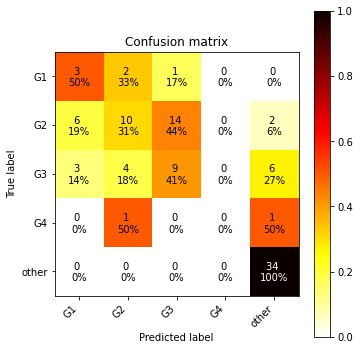

End of epoch 112 / 100 	 Time Taken: 160 sec
Train epoch 113
loss_G 1.175	
loss_G 1.006	
loss_G 0.996	
loss_G 0.907	
loss_G 0.895	
loss_G 0.864	
loss_G 0.902	
loss_G 0.916	
loss_G 0.911	
loss_G 0.913	
loss_G 0.891	
Accuracy: 0.5829383886255924


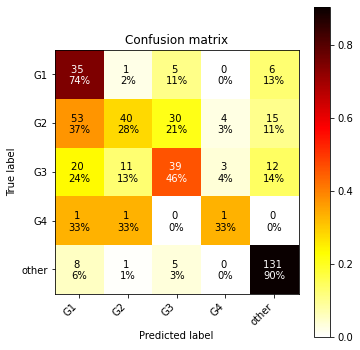

Val epoch 113
loss_G 1.191	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


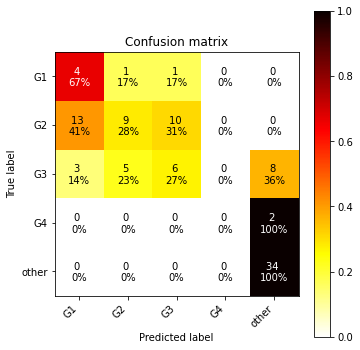

End of epoch 113 / 100 	 Time Taken: 153 sec
Train epoch 114
loss_G 1.09	
loss_G 0.911	
loss_G 0.987	
loss_G 1.083	
loss_G 1.06	
loss_G 1.001	
loss_G 0.982	
loss_G 0.967	
loss_G 0.948	
loss_G 0.932	
loss_G 0.948	
Accuracy: 0.5616113744075829


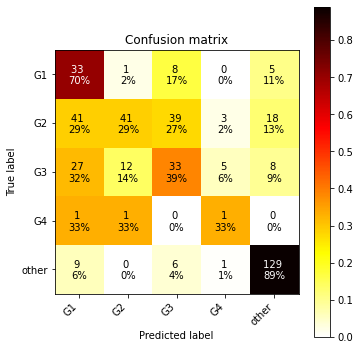

Val epoch 114
loss_G 1.077	
Accuracy:  0.5
Accuracy: 0.5


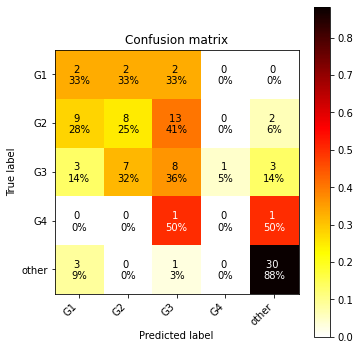

End of epoch 114 / 100 	 Time Taken: 151 sec
Train epoch 115
loss_G 0.718	
loss_G 0.908	
loss_G 0.972	
loss_G 0.919	
loss_G 0.912	
loss_G 0.869	
loss_G 0.855	
loss_G 0.857	
loss_G 0.857	
loss_G 0.859	
loss_G 0.859	
Accuracy: 0.580568720379147


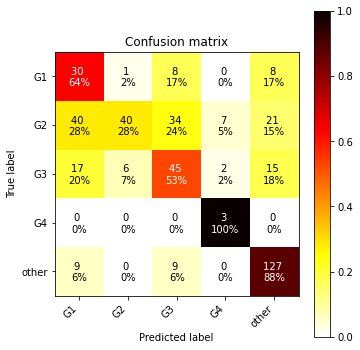

Val epoch 115
loss_G 1.013	
Accuracy:  0.625
Accuracy: 0.625


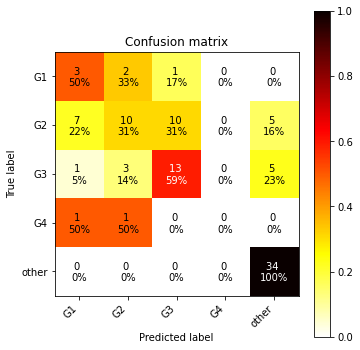

Saved model to ./models/1_grade_classification_in_NLST/115_..._.pt
Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 115 / 100 	 Time Taken: 159 sec
Train epoch 116
loss_G 0.721	
loss_G 0.749	
loss_G 0.757	
loss_G 0.779	
loss_G 0.752	
loss_G 0.805	
loss_G 0.786	
loss_G 0.795	
loss_G 0.786	
loss_G 0.797	
loss_G 0.815	
Accuracy: 0.6018957345971564


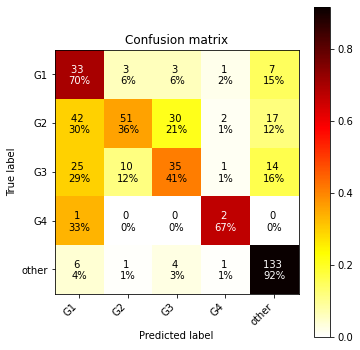

Val epoch 116
loss_G 1.262	
Accuracy:  0.5416666666666666
Accuracy: 0.5416666666666666


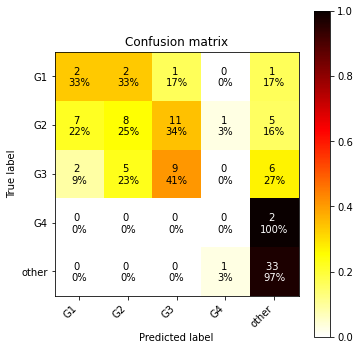

End of epoch 116 / 100 	 Time Taken: 153 sec
Train epoch 117
loss_G 0.982	
loss_G 0.968	
loss_G 1.025	
loss_G 1.069	
loss_G 1.0	
loss_G 0.978	
loss_G 0.992	
loss_G 0.956	
loss_G 0.933	
loss_G 0.954	
loss_G 0.972	
Accuracy: 0.566350710900474


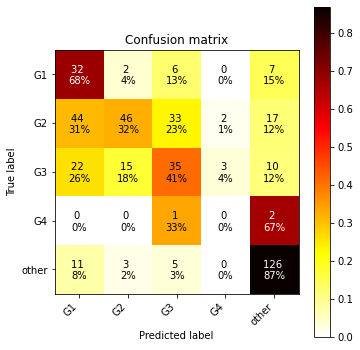

Val epoch 117
loss_G 1.387	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


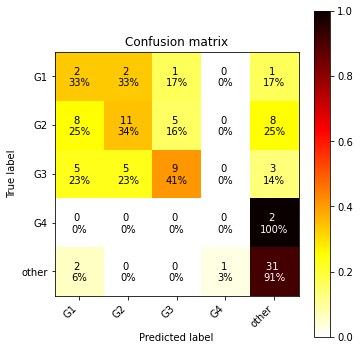

End of epoch 117 / 100 	 Time Taken: 166 sec
Train epoch 118
loss_G 0.885	
loss_G 0.925	
loss_G 0.875	
loss_G 0.829	
loss_G 0.856	
loss_G 0.915	
loss_G 0.88	
loss_G 0.857	
loss_G 0.853	
loss_G 0.848	
loss_G 0.858	
Accuracy: 0.5995260663507109


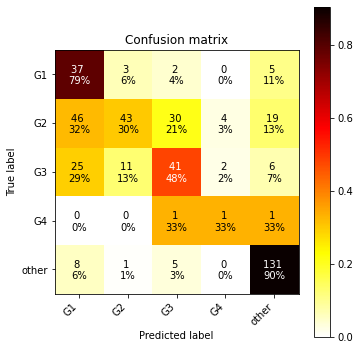

Val epoch 118
loss_G 1.167	
Accuracy:  0.5104166666666666
Accuracy: 0.5104166666666666


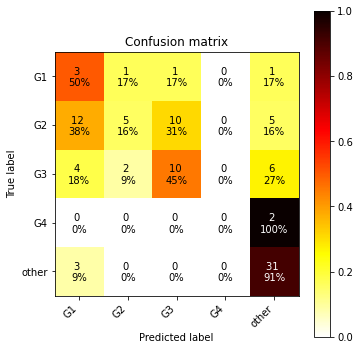

End of epoch 118 / 100 	 Time Taken: 168 sec
Train epoch 119
loss_G 0.652	
loss_G 0.617	
loss_G 0.652	
loss_G 0.734	
loss_G 0.852	
loss_G 0.893	
loss_G 0.896	
loss_G 0.883	
loss_G 0.879	
loss_G 0.901	
loss_G 0.909	
Accuracy: 0.5521327014218009


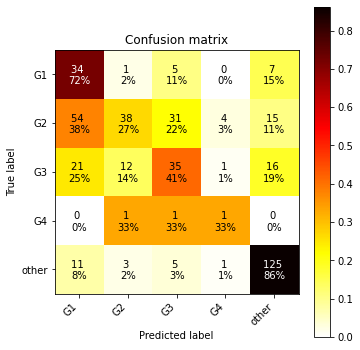

Val epoch 119
loss_G 0.979	
Accuracy:  0.625
Accuracy: 0.625


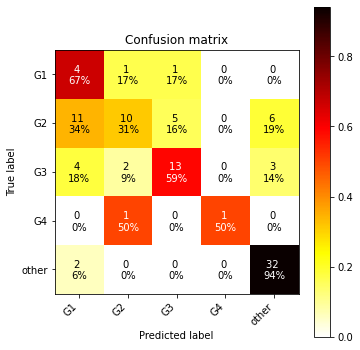

Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 119 / 100 	 Time Taken: 156 sec
Train epoch 120
loss_G 0.907	
loss_G 0.799	
loss_G 0.773	
loss_G 0.797	
loss_G 0.823	
loss_G 0.805	
loss_G 0.831	
loss_G 0.829	
loss_G 0.828	
loss_G 0.826	
loss_G 0.849	
Accuracy: 0.5687203791469194


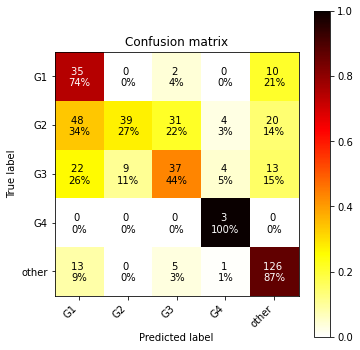

Val epoch 120
loss_G 1.074	
Accuracy:  0.5
Accuracy: 0.5


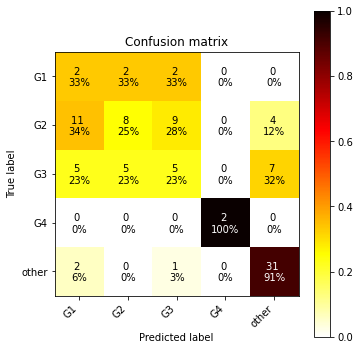

Saved model to ./models/1_grade_classification_in_NLST/120_..._.pt
End of epoch 120 / 100 	 Time Taken: 147 sec
Train epoch 121
loss_G 0.729	
loss_G 0.888	
loss_G 0.841	
loss_G 0.887	
loss_G 0.846	
loss_G 0.842	
loss_G 0.85	
loss_G 0.883	
loss_G 0.88	
loss_G 0.86	
loss_G 0.859	
Accuracy: 0.5521327014218009


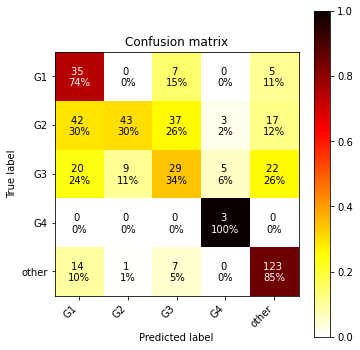

Val epoch 121
loss_G 1.177	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


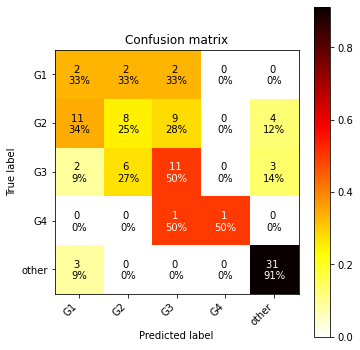

End of epoch 121 / 100 	 Time Taken: 153 sec
Train epoch 122
loss_G 0.773	
loss_G 0.782	
loss_G 0.765	
loss_G 0.83	
loss_G 0.849	
loss_G 0.846	
loss_G 0.839	
loss_G 0.833	
loss_G 0.874	
loss_G 0.855	
loss_G 0.889	
Accuracy: 0.5710900473933649


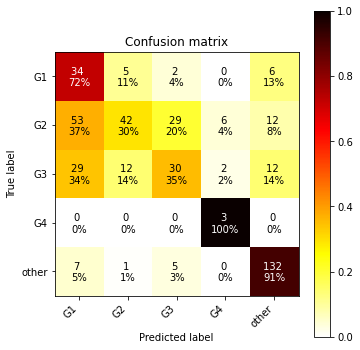

Val epoch 122
loss_G 1.097	
Accuracy:  0.59375
Accuracy: 0.59375


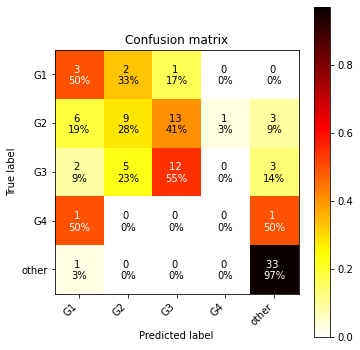

End of epoch 122 / 100 	 Time Taken: 141 sec
Train epoch 123
loss_G 0.918	
loss_G 0.95	
loss_G 0.873	
loss_G 0.861	
loss_G 0.817	
loss_G 0.824	
loss_G 0.843	
loss_G 0.834	
loss_G 0.84	
loss_G 0.843	
loss_G 0.869	
Accuracy: 0.5758293838862559


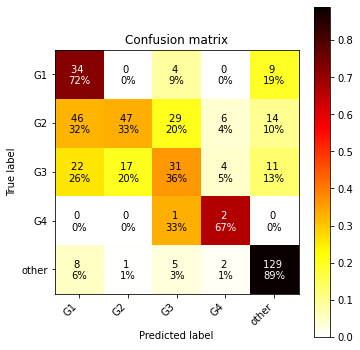

Val epoch 123
loss_G 1.289	
Accuracy:  0.53125
Accuracy: 0.53125


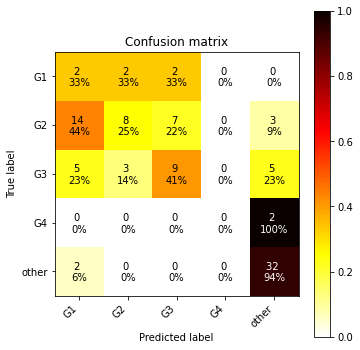

End of epoch 123 / 100 	 Time Taken: 149 sec
Train epoch 124
loss_G 0.685	
loss_G 0.667	
loss_G 0.698	
loss_G 0.757	
loss_G 0.767	
loss_G 0.783	
loss_G 0.777	
loss_G 0.767	
loss_G 0.774	
loss_G 0.819	
loss_G 0.834	
Accuracy: 0.5853080568720379


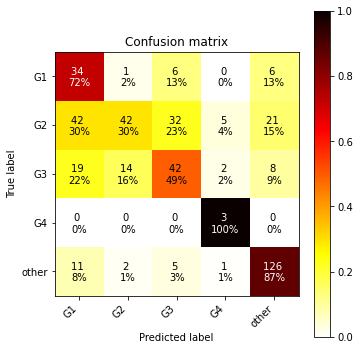

Val epoch 124
loss_G 1.525	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


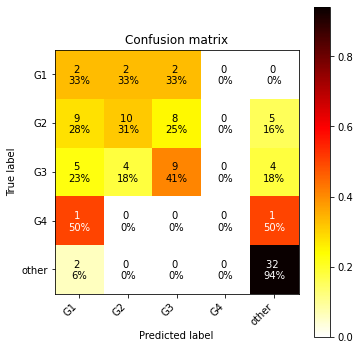

End of epoch 124 / 100 	 Time Taken: 145 sec
Train epoch 125
loss_G 0.492	
loss_G 0.673	
loss_G 0.687	
loss_G 0.745	
loss_G 0.742	
loss_G 0.767	
loss_G 0.774	
loss_G 0.804	
loss_G 0.797	
loss_G 0.823	
loss_G 0.825	
Accuracy: 0.5734597156398105


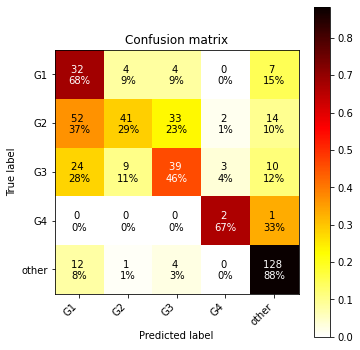

Val epoch 125
loss_G 1.116	
Accuracy:  0.625
Accuracy: 0.625


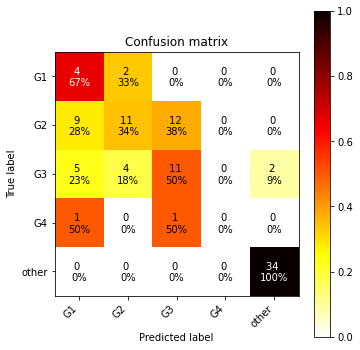

Saved model to ./models/1_grade_classification_in_NLST/125_..._.pt
End of epoch 125 / 100 	 Time Taken: 149 sec
Train epoch 126
loss_G 0.8	
loss_G 0.907	
loss_G 0.867	
loss_G 0.86	
loss_G 0.895	
loss_G 0.928	
loss_G 0.897	
loss_G 0.863	
loss_G 0.827	
loss_G 0.832	
loss_G 0.832	
Accuracy: 0.5734597156398105


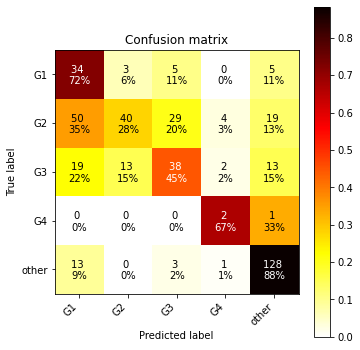

Val epoch 126
loss_G 1.173	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


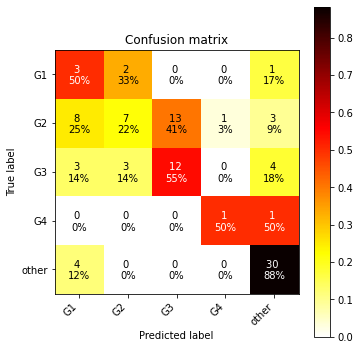

End of epoch 126 / 100 	 Time Taken: 161 sec
Train epoch 127
loss_G 0.835	
loss_G 0.815	
loss_G 0.84	
loss_G 0.831	
loss_G 0.798	
loss_G 0.788	
loss_G 0.791	
loss_G 0.771	
loss_G 0.768	
loss_G 0.766	
loss_G 0.798	
Accuracy: 0.5971563981042654


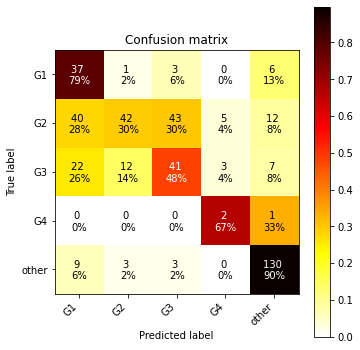

Val epoch 127
loss_G 1.062	
Accuracy:  0.6145833333333334
Accuracy: 0.6145833333333334


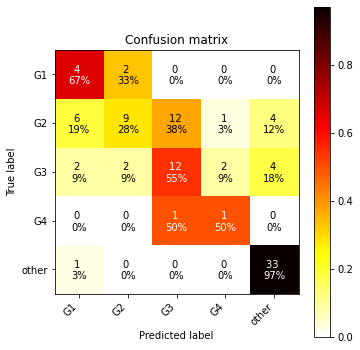

End of epoch 127 / 100 	 Time Taken: 148 sec
Train epoch 128
loss_G 0.899	
loss_G 0.813	
loss_G 0.88	
loss_G 0.906	
loss_G 0.921	
loss_G 0.887	
loss_G 0.859	
loss_G 0.863	
loss_G 0.835	
loss_G 0.797	
loss_G 0.835	
Accuracy: 0.6445497630331753


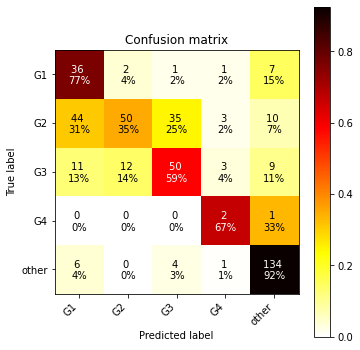

Val epoch 128
loss_G 1.092	
Accuracy:  0.5104166666666666
Accuracy: 0.5104166666666666


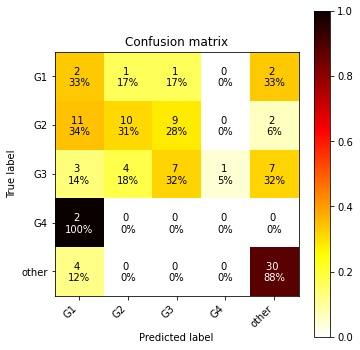

End of epoch 128 / 100 	 Time Taken: 152 sec
Train epoch 129
loss_G 0.478	
loss_G 0.582	
loss_G 0.673	
loss_G 0.747	
loss_G 0.743	
loss_G 0.738	
loss_G 0.774	
loss_G 0.785	
loss_G 0.786	
loss_G 0.796	
loss_G 0.839	
Accuracy: 0.6279620853080569


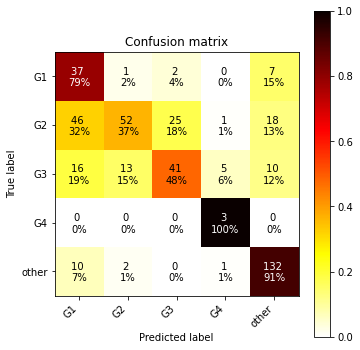

Val epoch 129
loss_G 1.488	
Accuracy:  0.53125
Accuracy: 0.53125


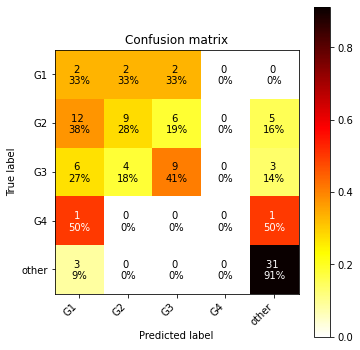

End of epoch 129 / 100 	 Time Taken: 157 sec
Train epoch 130
loss_G 0.954	
loss_G 0.846	
loss_G 0.793	
loss_G 0.769	
loss_G 0.784	
loss_G 0.8	
loss_G 0.77	
loss_G 0.769	
loss_G 0.791	
loss_G 0.81	
loss_G 0.846	
Accuracy: 0.5971563981042654


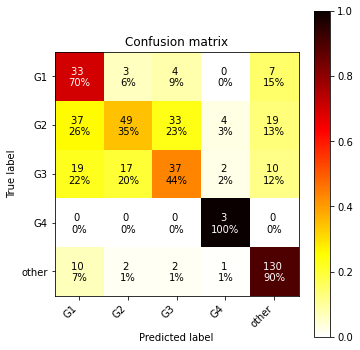

Val epoch 130
loss_G 1.073	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


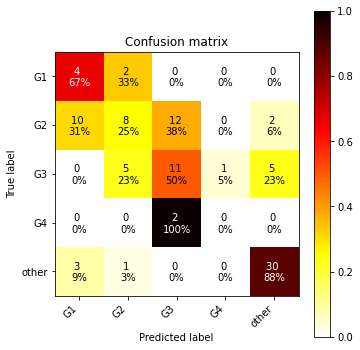

Saved model to ./models/1_grade_classification_in_NLST/130_..._.pt
End of epoch 130 / 100 	 Time Taken: 145 sec
Train epoch 131
loss_G 0.758	
loss_G 0.708	
loss_G 0.72	
loss_G 0.813	
loss_G 0.794	
loss_G 0.816	
loss_G 0.876	
loss_G 0.905	
loss_G 0.906	
loss_G 0.899	
loss_G 0.892	
Accuracy: 0.5924170616113744


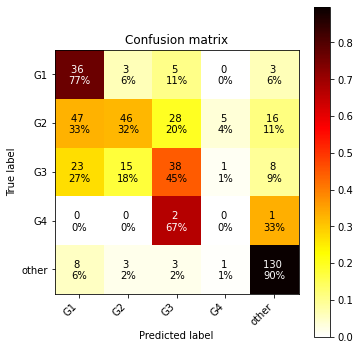

Val epoch 131
loss_G 1.441	
Accuracy:  0.5208333333333334
Accuracy: 0.5208333333333334


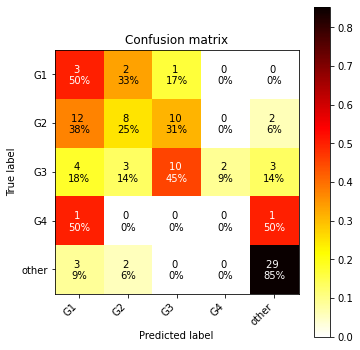

End of epoch 131 / 100 	 Time Taken: 165 sec
Train epoch 132
loss_G 1.077	
loss_G 0.95	
loss_G 0.852	
loss_G 0.815	
loss_G 0.824	
loss_G 0.837	
loss_G 0.866	
loss_G 0.845	
loss_G 0.826	
loss_G 0.817	
loss_G 0.871	
Accuracy: 0.6066350710900474


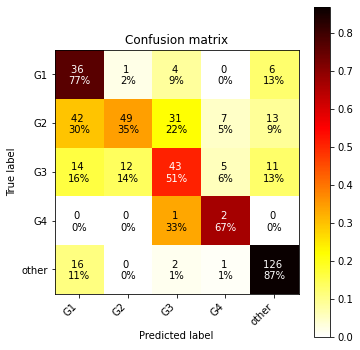

Val epoch 132
loss_G 1.18	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


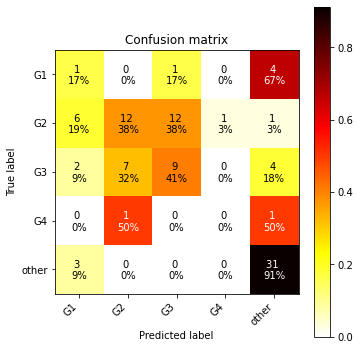

End of epoch 132 / 100 	 Time Taken: 144 sec
Train epoch 133
loss_G 0.812	
loss_G 0.765	
loss_G 0.778	
loss_G 0.808	
loss_G 0.778	
loss_G 0.787	
loss_G 0.784	
loss_G 0.764	
loss_G 0.756	
loss_G 0.756	
loss_G 0.794	
Accuracy: 0.6066350710900474


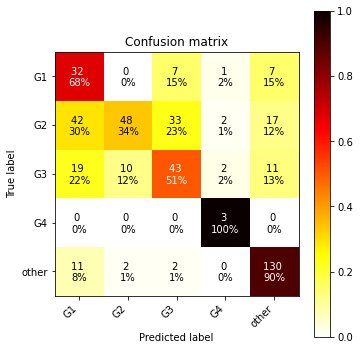

Val epoch 133
loss_G 1.236	
Accuracy:  0.5729166666666666
Accuracy: 0.5729166666666666


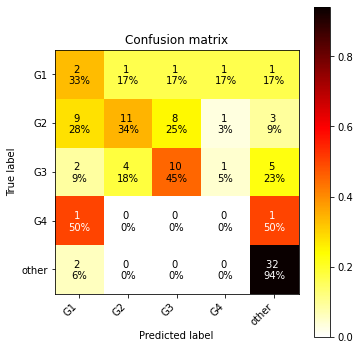

End of epoch 133 / 100 	 Time Taken: 149 sec
Train epoch 134
loss_G 1.075	
loss_G 0.832	
loss_G 0.77	
loss_G 0.752	
loss_G 0.781	
loss_G 0.824	
loss_G 0.796	
loss_G 0.817	
loss_G 0.801	
loss_G 0.797	
loss_G 0.772	
Accuracy: 0.5947867298578199


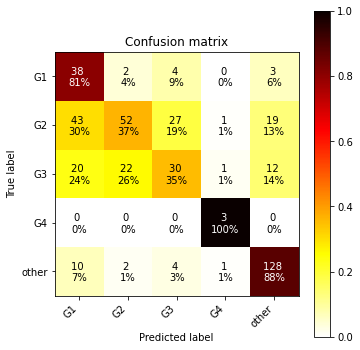

Val epoch 134
loss_G 1.101	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


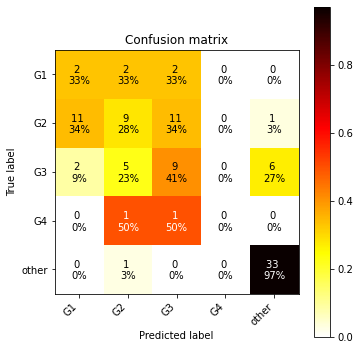

End of epoch 134 / 100 	 Time Taken: 153 sec
Train epoch 135
loss_G 0.795	
loss_G 0.767	
loss_G 0.816	
loss_G 0.857	
loss_G 0.84	
loss_G 0.821	
loss_G 0.803	
loss_G 0.82	
loss_G 0.813	
loss_G 0.819	
loss_G 0.854	
Accuracy: 0.6066350710900474


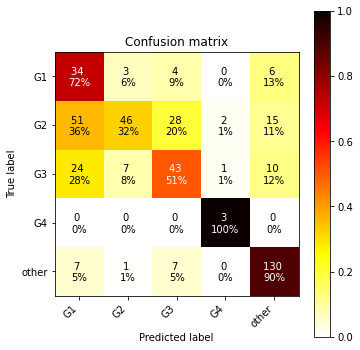

Val epoch 135
loss_G 1.254	
Accuracy:  0.59375
Accuracy: 0.59375


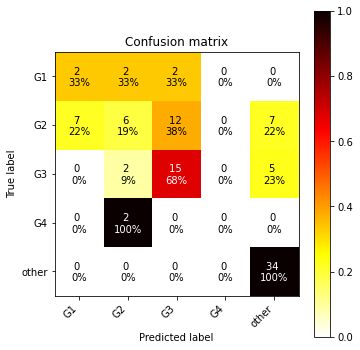

Saved model to ./models/1_grade_classification_in_NLST/135_..._.pt
End of epoch 135 / 100 	 Time Taken: 155 sec
Train epoch 136
loss_G 0.659	
loss_G 0.743	
loss_G 0.672	
loss_G 0.683	
loss_G 0.758	
loss_G 0.8	
loss_G 0.802	
loss_G 0.803	
loss_G 0.87	
loss_G 0.85	
loss_G 0.832	
Accuracy: 0.6303317535545023


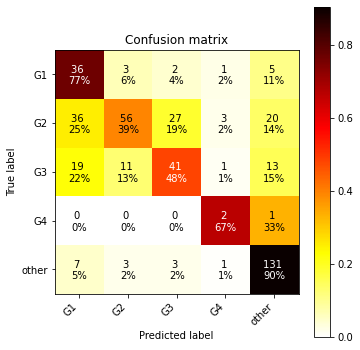

Val epoch 136
loss_G 1.512	
Accuracy:  0.5625
Accuracy: 0.5625


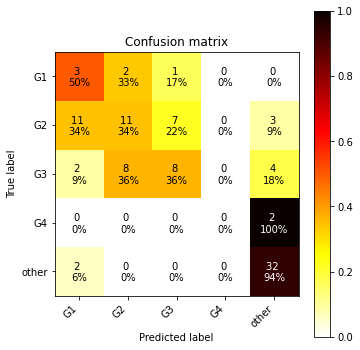

End of epoch 136 / 100 	 Time Taken: 168 sec
Train epoch 137
loss_G 0.519	
loss_G 0.611	
loss_G 0.61	
loss_G 0.66	
loss_G 0.666	
loss_G 0.694	
loss_G 0.713	
loss_G 0.732	
loss_G 0.733	
loss_G 0.748	
loss_G 0.786	
Accuracy: 0.5995260663507109


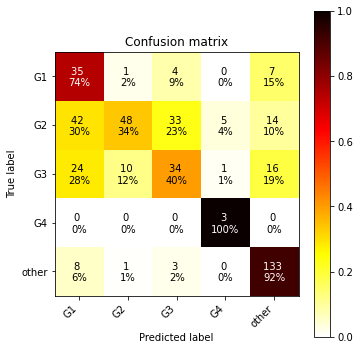

Val epoch 137
loss_G 1.331	
Accuracy:  0.5416666666666666
Accuracy: 0.5416666666666666


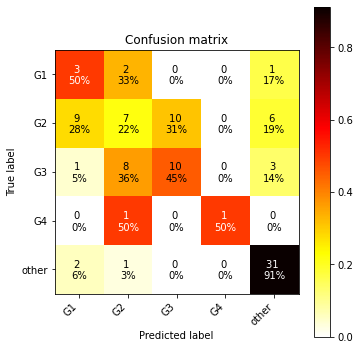

End of epoch 137 / 100 	 Time Taken: 157 sec
Train epoch 138
loss_G 0.858	
loss_G 0.742	
loss_G 0.734	
loss_G 0.794	
loss_G 0.813	
loss_G 0.782	
loss_G 0.777	
loss_G 0.784	
loss_G 0.78	
loss_G 0.774	
loss_G 0.761	
Accuracy: 0.6303317535545023


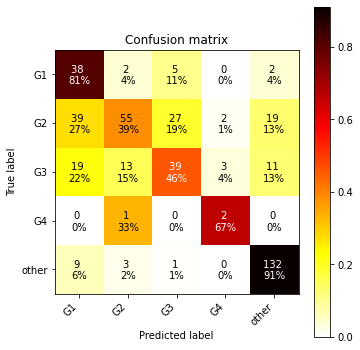

Val epoch 138
loss_G 1.045	
Accuracy:  0.5625
Accuracy: 0.5625


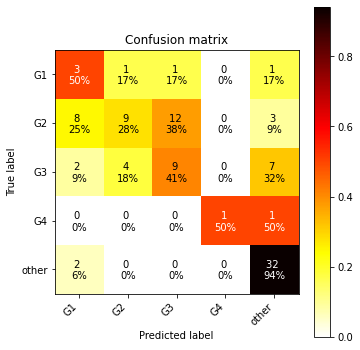

End of epoch 138 / 100 	 Time Taken: 146 sec
Train epoch 139
loss_G 0.823	
loss_G 0.78	
loss_G 0.88	
loss_G 0.864	
loss_G 0.845	
loss_G 0.814	
loss_G 0.823	
loss_G 0.828	
loss_G 0.848	
loss_G 0.906	
loss_G 0.906	
Accuracy: 0.5710900473933649


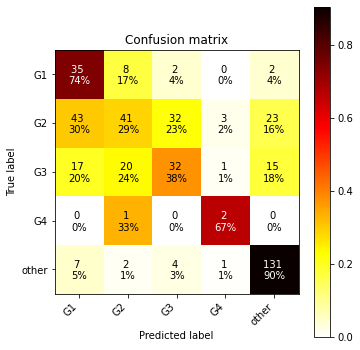

Val epoch 139
loss_G 1.574	
Accuracy:  0.5
Accuracy: 0.5


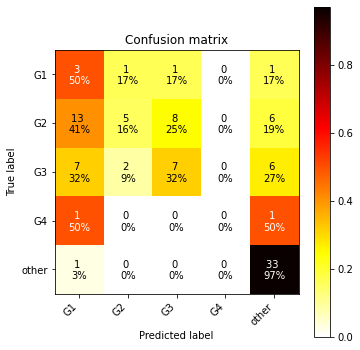

End of epoch 139 / 100 	 Time Taken: 145 sec
Train epoch 140
loss_G 1.009	
loss_G 0.827	
loss_G 0.766	
loss_G 0.842	
loss_G 0.825	
loss_G 0.829	
loss_G 0.821	
loss_G 0.813	
loss_G 0.789	
loss_G 0.779	
loss_G 0.823	
Accuracy: 0.6232227488151659


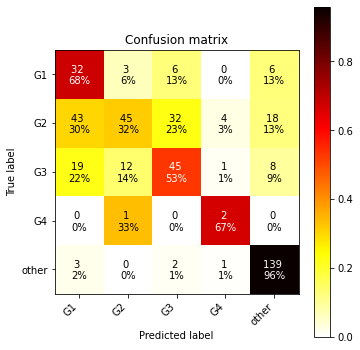

Val epoch 140
loss_G 1.274	
Accuracy:  0.5208333333333334
Accuracy: 0.5208333333333334


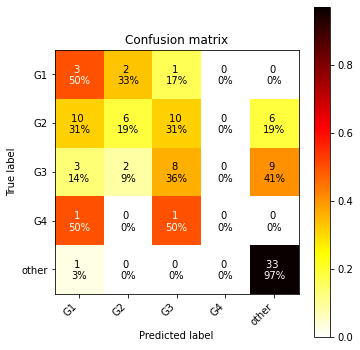

Saved model to ./models/1_grade_classification_in_NLST/140_..._.pt
End of epoch 140 / 100 	 Time Taken: 142 sec
Train epoch 141
loss_G 0.924	
loss_G 0.763	
loss_G 0.759	
loss_G 0.793	
loss_G 0.791	
loss_G 0.76	
loss_G 0.771	
loss_G 0.8	
loss_G 0.786	
loss_G 0.808	
loss_G 0.87	
Accuracy: 0.5924170616113744


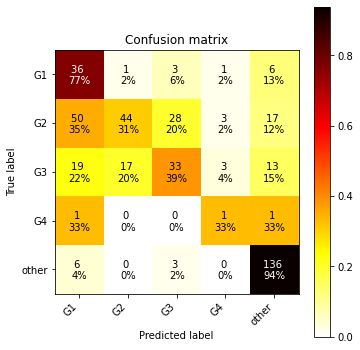

Val epoch 141
loss_G 1.047	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


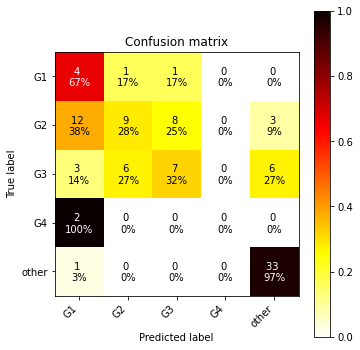

End of epoch 141 / 100 	 Time Taken: 140 sec
Train epoch 142
loss_G 0.596	
loss_G 0.637	
loss_G 0.727	
loss_G 0.753	
loss_G 0.899	
loss_G 0.869	
loss_G 0.873	
loss_G 0.841	
loss_G 0.887	
loss_G 0.857	
loss_G 0.842	
Accuracy: 0.6113744075829384


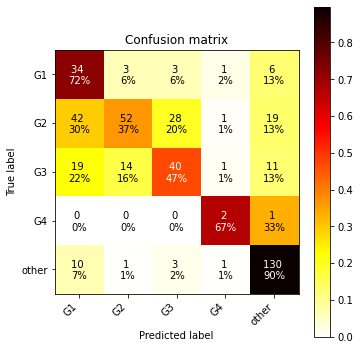

Val epoch 142
loss_G 1.154	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


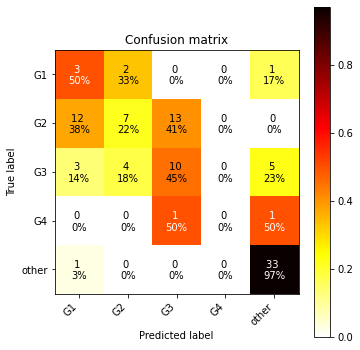

End of epoch 142 / 100 	 Time Taken: 140 sec
Train epoch 143
loss_G 0.454	
loss_G 0.585	
loss_G 0.682	
loss_G 0.694	
loss_G 0.735	
loss_G 0.762	
loss_G 0.74	
loss_G 0.73	
loss_G 0.748	
loss_G 0.763	
loss_G 0.767	
Accuracy: 0.6232227488151659


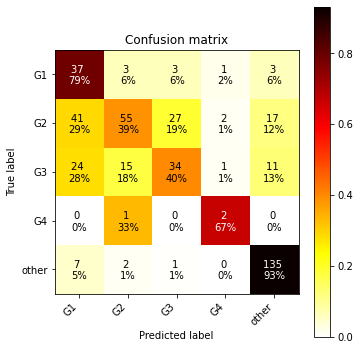

Val epoch 143
loss_G 1.11	
Accuracy:  0.625
Accuracy: 0.625


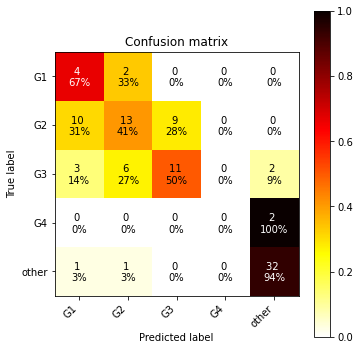

End of epoch 143 / 100 	 Time Taken: 138 sec
Train epoch 144
loss_G 0.553	
loss_G 0.748	
loss_G 0.758	
loss_G 0.77	
loss_G 0.769	
loss_G 0.802	
loss_G 0.775	
loss_G 0.765	
loss_G 0.77	
loss_G 0.771	
loss_G 0.805	
Accuracy: 0.5971563981042654


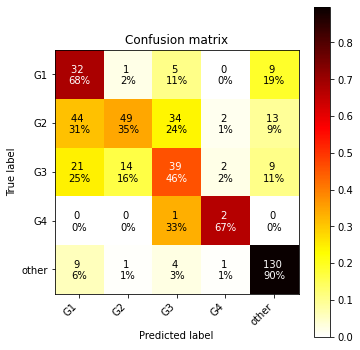

Val epoch 144
loss_G 1.036	
Accuracy:  0.625
Accuracy: 0.625


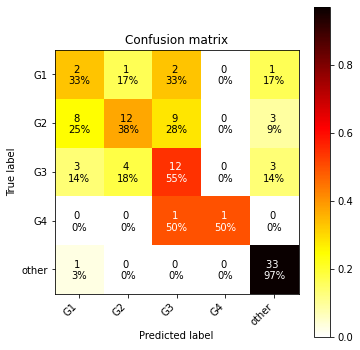

End of epoch 144 / 100 	 Time Taken: 136 sec
Train epoch 145
loss_G 0.905	
loss_G 0.761	
loss_G 0.742	
loss_G 0.78	
loss_G 0.784	
loss_G 0.81	
loss_G 0.775	
loss_G 0.81	
loss_G 0.788	
loss_G 0.809	
loss_G 0.779	
Accuracy: 0.6279620853080569


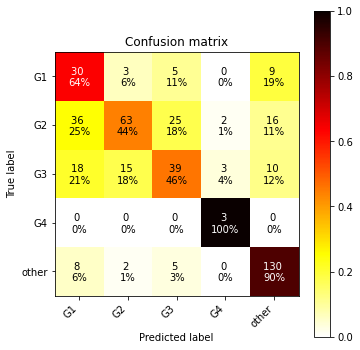

Val epoch 145
loss_G 1.272	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


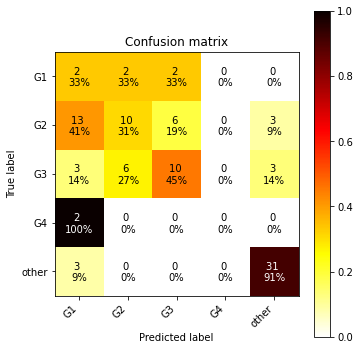

Saved model to ./models/1_grade_classification_in_NLST/145_..._.pt
End of epoch 145 / 100 	 Time Taken: 133 sec
Train epoch 146
loss_G 0.666	
loss_G 0.733	
loss_G 0.704	
loss_G 0.747	
loss_G 0.76	
loss_G 0.764	
loss_G 0.774	
loss_G 0.765	
loss_G 0.748	
loss_G 0.763	
loss_G 0.81	
Accuracy: 0.5971563981042654


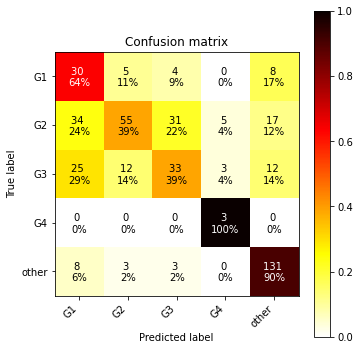

Val epoch 146
loss_G 1.384	
Accuracy:  0.5833333333333334
Accuracy: 0.5833333333333334


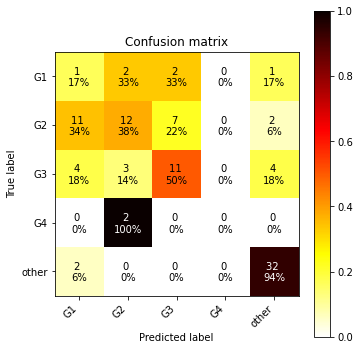

End of epoch 146 / 100 	 Time Taken: 124 sec
Train epoch 147
loss_G 0.551	
loss_G 0.686	
loss_G 0.715	
loss_G 0.761	
loss_G 0.755	
loss_G 0.784	
loss_G 0.791	
loss_G 0.762	
loss_G 0.757	
loss_G 0.749	
loss_G 0.779	
Accuracy: 0.5947867298578199


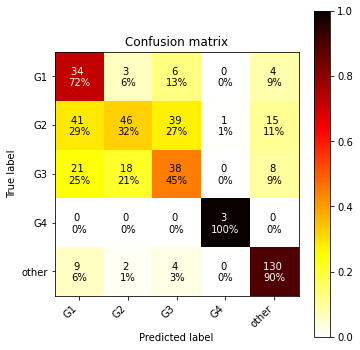

Val epoch 147
loss_G 1.452	
Accuracy:  0.4895833333333333
Accuracy: 0.4895833333333333


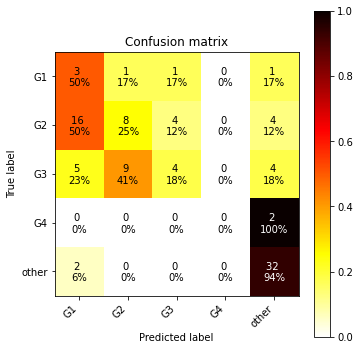

End of epoch 147 / 100 	 Time Taken: 123 sec
Train epoch 148
loss_G 0.871	
loss_G 0.763	
loss_G 0.7	
loss_G 0.695	
loss_G 0.683	
loss_G 0.707	
loss_G 0.711	
loss_G 0.729	
loss_G 0.811	
loss_G 0.817	
loss_G 0.898	
Accuracy: 0.6327014218009479


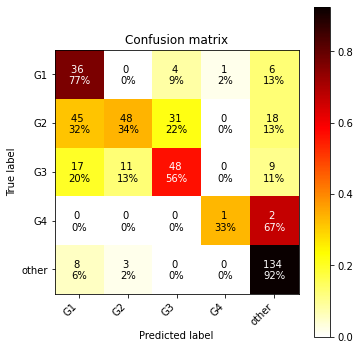

Val epoch 148
loss_G 1.285	
Accuracy:  0.5416666666666666
Accuracy: 0.5416666666666666


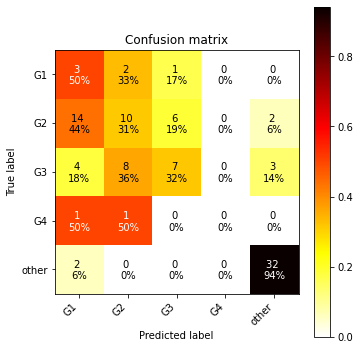

End of epoch 148 / 100 	 Time Taken: 120 sec
Train epoch 149
loss_G 0.617	
loss_G 0.676	
loss_G 0.778	
loss_G 0.779	
loss_G 0.797	
loss_G 0.813	
loss_G 0.812	
loss_G 0.795	
loss_G 0.847	
loss_G 0.823	
loss_G 0.889	
Accuracy: 0.6137440758293838


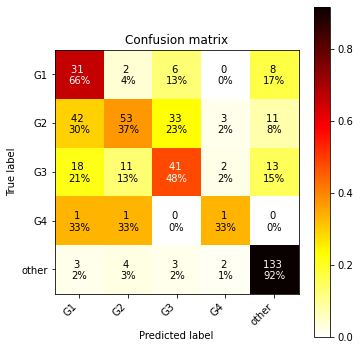

Val epoch 149
loss_G 1.303	
Accuracy:  0.5833333333333334
Accuracy: 0.5833333333333334


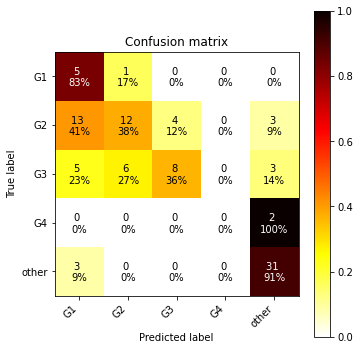

End of epoch 149 / 100 	 Time Taken: 118 sec
Train epoch 150
loss_G 0.67	
loss_G 0.658	
loss_G 0.71	
loss_G 0.698	
loss_G 0.744	
loss_G 0.757	
loss_G 0.737	
loss_G 0.747	
loss_G 0.72	
loss_G 0.732	
loss_G 0.784	
Accuracy: 0.6184834123222749


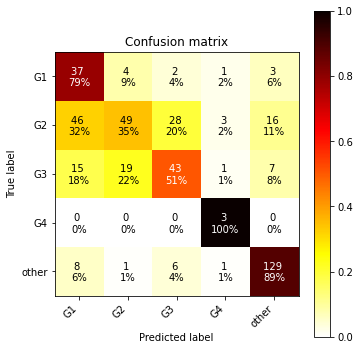

Val epoch 150
loss_G 1.086	
Accuracy:  0.5208333333333334
Accuracy: 0.5208333333333334


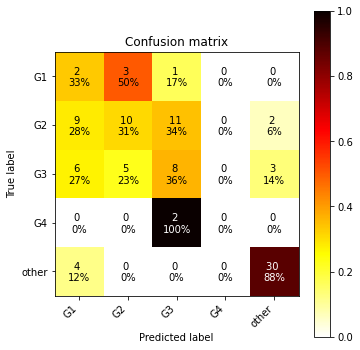

Saved model to ./models/1_grade_classification_in_NLST/150_..._.pt
End of epoch 150 / 100 	 Time Taken: 128 sec
Train epoch 151
loss_G 1.055	
loss_G 0.778	
loss_G 0.744	
loss_G 0.747	
loss_G 0.74	
loss_G 0.72	
loss_G 0.707	
loss_G 0.758	
loss_G 0.76	
loss_G 0.779	
loss_G 0.76	
Accuracy: 0.6255924170616114


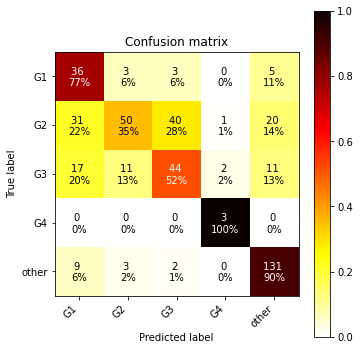

Val epoch 151
loss_G 1.428	
Accuracy:  0.5416666666666666
Accuracy: 0.5416666666666666


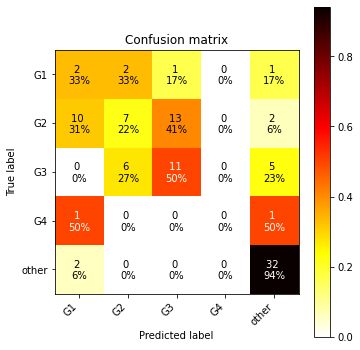

End of epoch 151 / 100 	 Time Taken: 134 sec
Train epoch 152
loss_G 0.785	
loss_G 0.768	
loss_G 0.887	
loss_G 0.829	
loss_G 0.839	
loss_G 0.795	
loss_G 0.766	
loss_G 0.806	
loss_G 0.802	
loss_G 0.788	
loss_G 0.83	
Accuracy: 0.6398104265402843


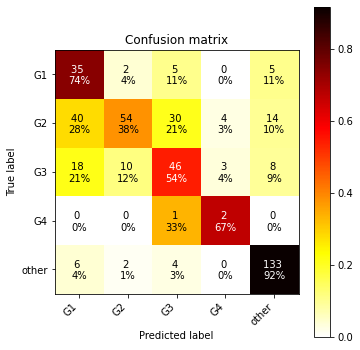

Val epoch 152
loss_G 1.421	
Accuracy:  0.5416666666666666
Accuracy: 0.5416666666666666


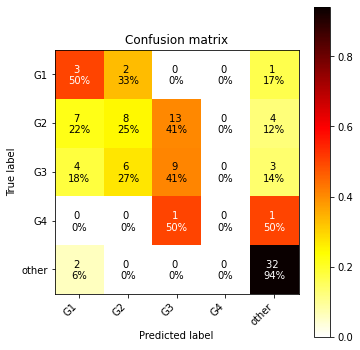

End of epoch 152 / 100 	 Time Taken: 138 sec
Train epoch 153
loss_G 0.877	
loss_G 0.846	
loss_G 0.788	
loss_G 0.761	
loss_G 0.72	
loss_G 0.69	
loss_G 0.707	
loss_G 0.719	
loss_G 0.719	
loss_G 0.733	
loss_G 0.729	
Accuracy: 0.6018957345971564


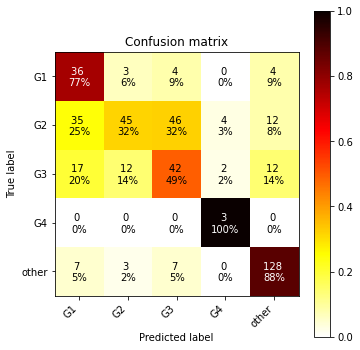

Val epoch 153
loss_G 1.291	
Accuracy:  0.53125
Accuracy: 0.53125


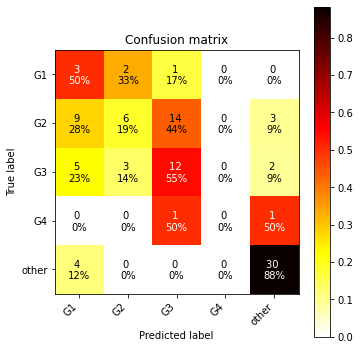

End of epoch 153 / 100 	 Time Taken: 148 sec
Train epoch 154
loss_G 0.79	
loss_G 0.712	
loss_G 0.735	
loss_G 0.825	
loss_G 0.782	
loss_G 0.819	
loss_G 0.812	
loss_G 0.791	
loss_G 0.795	
loss_G 0.777	
loss_G 0.786	
Accuracy: 0.6398104265402843


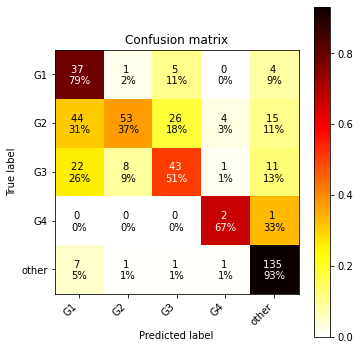

Val epoch 154
loss_G 1.235	
Accuracy:  0.5625
Accuracy: 0.5625


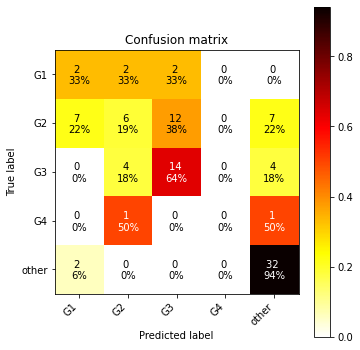

End of epoch 154 / 100 	 Time Taken: 144 sec
Train epoch 155
loss_G 0.641	
loss_G 0.666	
loss_G 0.664	
loss_G 0.671	
loss_G 0.727	
loss_G 0.742	
loss_G 0.734	
loss_G 0.769	
loss_G 0.761	
loss_G 0.757	
loss_G 0.752	
Accuracy: 0.6303317535545023


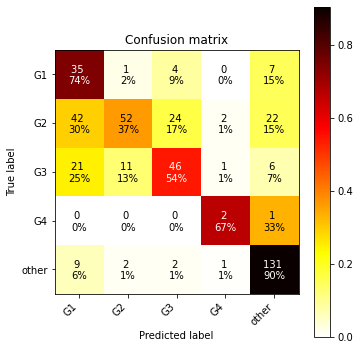

Val epoch 155
loss_G 1.137	
Accuracy:  0.6145833333333334
Accuracy: 0.6145833333333334


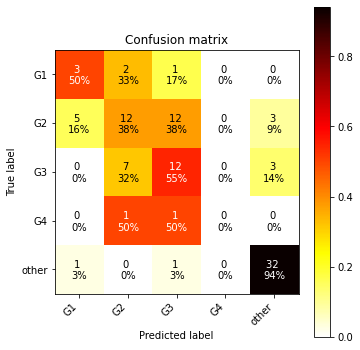

Saved model to ./models/1_grade_classification_in_NLST/155_..._.pt
End of epoch 155 / 100 	 Time Taken: 142 sec
Train epoch 156
loss_G 0.63	
loss_G 0.719	
loss_G 0.668	
loss_G 0.755	
loss_G 0.725	
loss_G 0.736	
loss_G 0.745	
loss_G 0.768	
loss_G 0.758	
loss_G 0.765	
loss_G 0.756	
Accuracy: 0.6445497630331753


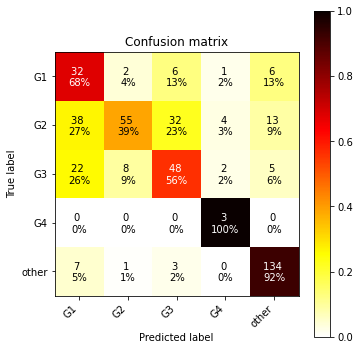

Val epoch 156
loss_G 0.859	
Accuracy:  0.6041666666666666
Accuracy: 0.6041666666666666


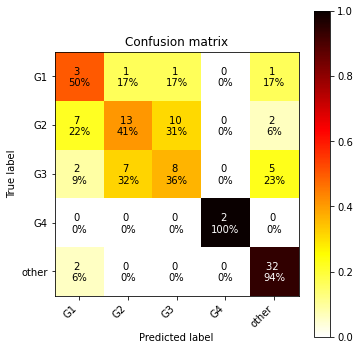

Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
End of epoch 156 / 100 	 Time Taken: 140 sec
Train epoch 157
loss_G 0.726	
loss_G 0.735	
loss_G 0.72	
loss_G 0.706	
loss_G 0.726	
loss_G 0.717	
loss_G 0.689	
loss_G 0.704	
loss_G 0.699	
loss_G 0.688	
loss_G 0.703	
Accuracy: 0.6398104265402843


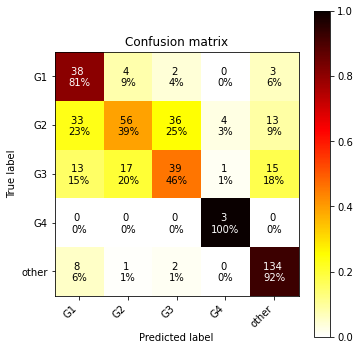

Val epoch 157
loss_G 1.067	
Accuracy:  0.5833333333333334
Accuracy: 0.5833333333333334


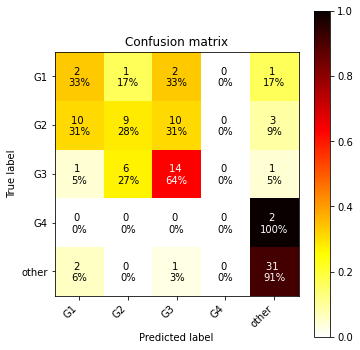

End of epoch 157 / 100 	 Time Taken: 144 sec
Train epoch 158
loss_G 0.791	
loss_G 0.957	
loss_G 0.836	
loss_G 0.8	
loss_G 0.886	
loss_G 0.881	
loss_G 0.84	
loss_G 0.808	
loss_G 0.814	
loss_G 0.807	
loss_G 0.859	
Accuracy: 0.6350710900473934


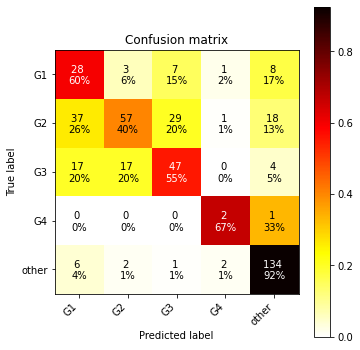

Val epoch 158
loss_G 1.429	
Accuracy:  0.5625
Accuracy: 0.5625


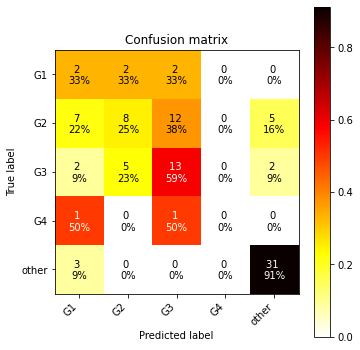

End of epoch 158 / 100 	 Time Taken: 141 sec
Train epoch 159
loss_G 0.891	
loss_G 0.835	
loss_G 0.769	
loss_G 0.759	
loss_G 0.714	
loss_G 0.713	
loss_G 0.725	
loss_G 0.737	
loss_G 0.745	
loss_G 0.776	
loss_G 0.789	
Accuracy: 0.580568720379147


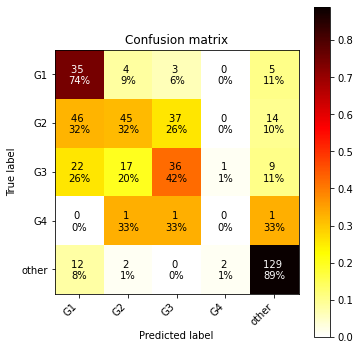

Val epoch 159
loss_G 0.944	
Accuracy:  0.5729166666666666
Accuracy: 0.5729166666666666


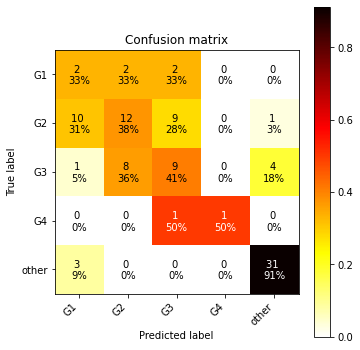

End of epoch 159 / 100 	 Time Taken: 131 sec
Train epoch 160
loss_G 0.71	
loss_G 0.72	
loss_G 0.697	
loss_G 0.712	
loss_G 0.795	
loss_G 0.796	
loss_G 0.843	
loss_G 0.82	
loss_G 0.816	
loss_G 0.817	
loss_G 0.809	
Accuracy: 0.6208530805687204


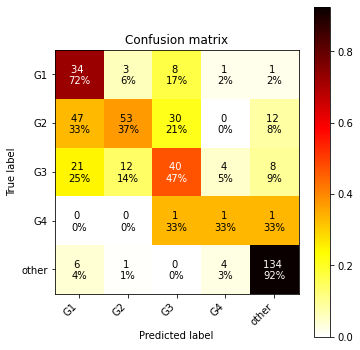

Val epoch 160
loss_G 0.965	
Accuracy:  0.6145833333333334
Accuracy: 0.6145833333333334


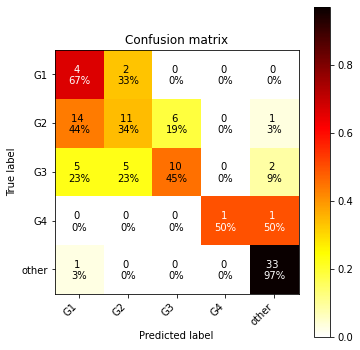

Saved model to ./models/1_grade_classification_in_NLST/160_..._.pt
End of epoch 160 / 100 	 Time Taken: 128 sec
Train epoch 161
loss_G 0.673	
loss_G 0.574	
loss_G 0.559	
loss_G 0.646	
loss_G 0.64	
loss_G 0.703	
loss_G 0.702	
loss_G 0.75	
loss_G 0.76	
loss_G 0.777	
loss_G 0.754	
Accuracy: 0.5995260663507109


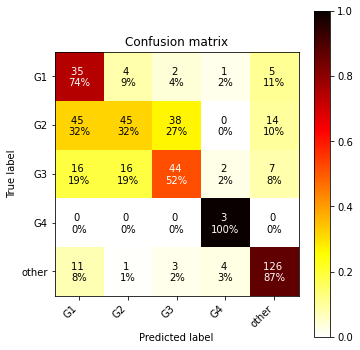

Val epoch 161
loss_G 1.025	
Accuracy:  0.5208333333333334
Accuracy: 0.5208333333333334


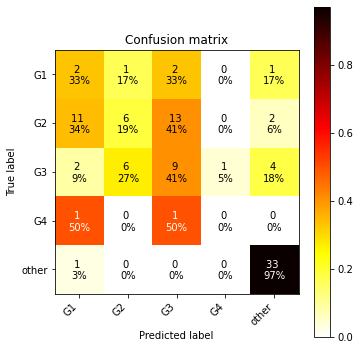

End of epoch 161 / 100 	 Time Taken: 125 sec
Train epoch 162
loss_G 0.649	
loss_G 0.708	
loss_G 0.83	
loss_G 0.825	
loss_G 0.853	
loss_G 0.852	
loss_G 0.813	
loss_G 0.805	
loss_G 0.801	
loss_G 0.772	
loss_G 0.756	
Accuracy: 0.6303317535545023


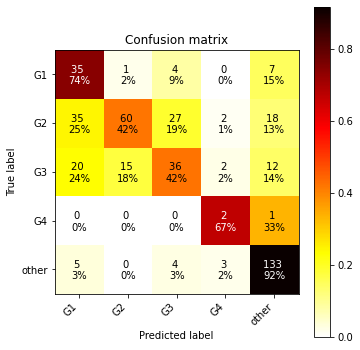

Val epoch 162
loss_G 1.186	
Accuracy:  0.5208333333333334
Accuracy: 0.5208333333333334


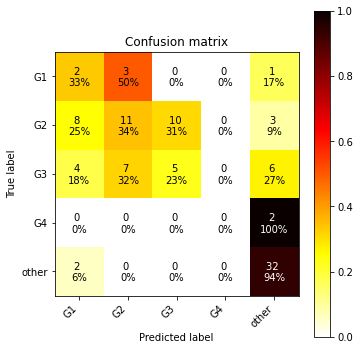

End of epoch 162 / 100 	 Time Taken: 122 sec
Train epoch 163
loss_G 0.499	
loss_G 0.653	
loss_G 0.61	
loss_G 0.639	
loss_G 0.643	
loss_G 0.68	
loss_G 0.694	
loss_G 0.669	
loss_G 0.687	
loss_G 0.674	
loss_G 0.688	
Accuracy: 0.6611374407582938


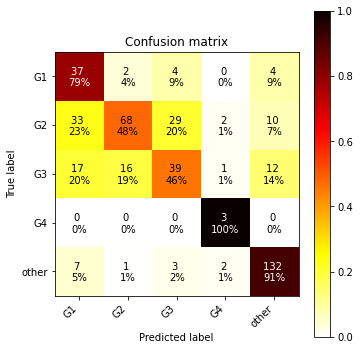

Val epoch 163
loss_G 1.449	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


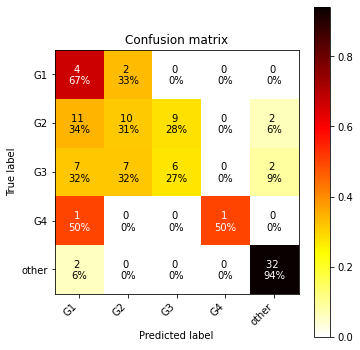

End of epoch 163 / 100 	 Time Taken: 124 sec
Train epoch 164
loss_G 0.597	
loss_G 0.56	
loss_G 0.614	
loss_G 0.699	
loss_G 0.706	
loss_G 0.712	
loss_G 0.746	
loss_G 0.771	
loss_G 0.765	
loss_G 0.778	
loss_G 0.783	
Accuracy: 0.6398104265402843


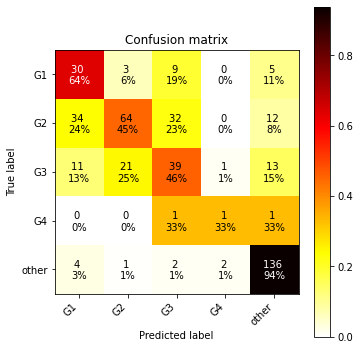

Val epoch 164
loss_G 1.104	
Accuracy:  0.5833333333333334
Accuracy: 0.5833333333333334


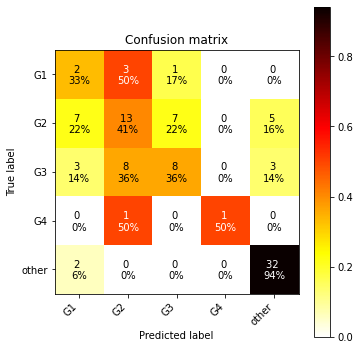

End of epoch 164 / 100 	 Time Taken: 122 sec
Train epoch 165
loss_G 0.636	
loss_G 0.851	
loss_G 0.761	
loss_G 0.783	
loss_G 0.768	
loss_G 0.756	
loss_G 0.766	
loss_G 0.764	
loss_G 0.784	
loss_G 0.798	
loss_G 0.787	
Accuracy: 0.6042654028436019


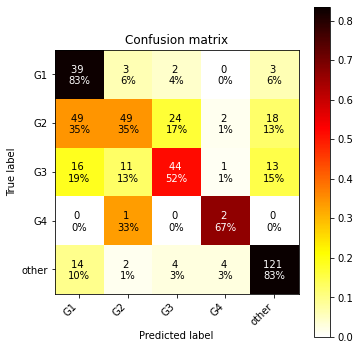

Val epoch 165
loss_G 1.342	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


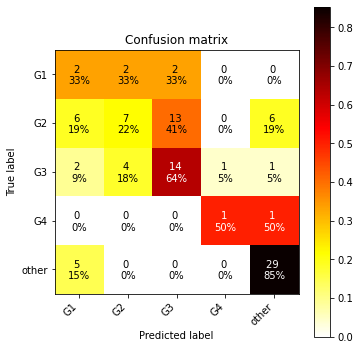

Saved model to ./models/1_grade_classification_in_NLST/165_..._.pt
End of epoch 165 / 100 	 Time Taken: 124 sec
Train epoch 166
loss_G 0.682	
loss_G 0.744	
loss_G 0.787	
loss_G 0.78	
loss_G 0.803	
loss_G 0.77	
loss_G 0.814	
loss_G 0.817	
loss_G 0.833	
loss_G 0.823	
loss_G 0.854	
Accuracy: 0.5947867298578199


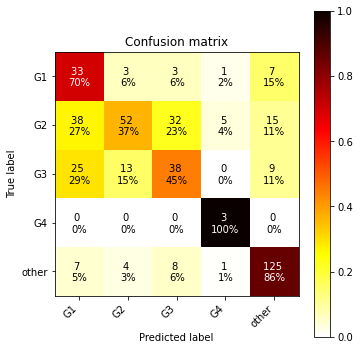

Val epoch 166
loss_G 1.116	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


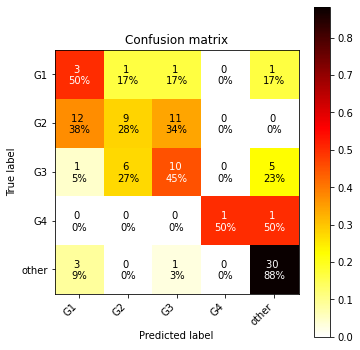

End of epoch 166 / 100 	 Time Taken: 120 sec
Train epoch 167
loss_G 0.889	
loss_G 0.668	
loss_G 0.693	
loss_G 0.673	
loss_G 0.712	
loss_G 0.729	
loss_G 0.723	
loss_G 0.712	
loss_G 0.717	
loss_G 0.721	
loss_G 0.774	
Accuracy: 0.590047393364929


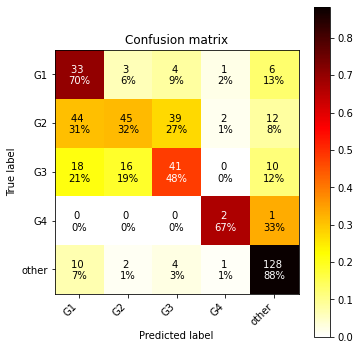

Val epoch 167
loss_G 1.373	
Accuracy:  0.6041666666666666
Accuracy: 0.6041666666666666


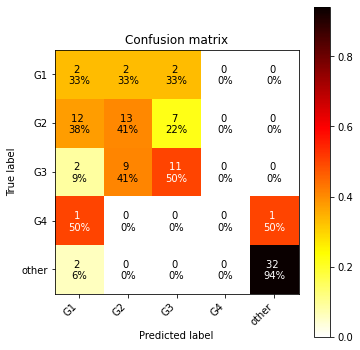

End of epoch 167 / 100 	 Time Taken: 121 sec
Train epoch 168
loss_G 1.068	
loss_G 0.868	
loss_G 0.73	
loss_G 0.712	
loss_G 0.725	
loss_G 0.785	
loss_G 0.784	
loss_G 0.754	
loss_G 0.743	
loss_G 0.744	
loss_G 0.72	
Accuracy: 0.6445497630331753


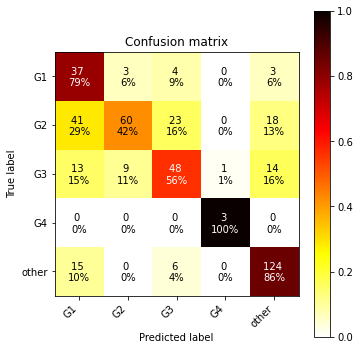

Val epoch 168
loss_G 1.312	
Accuracy:  0.53125
Accuracy: 0.53125


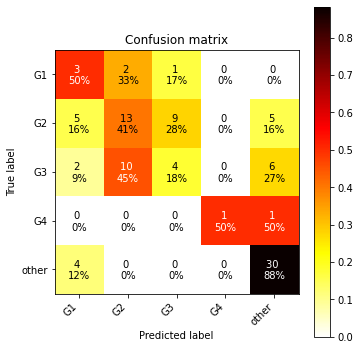

End of epoch 168 / 100 	 Time Taken: 118 sec
Train epoch 169
loss_G 1.024	
loss_G 1.007	
loss_G 0.91	
loss_G 0.895	
loss_G 0.864	
loss_G 0.862	
loss_G 0.876	
loss_G 0.851	
loss_G 0.84	
loss_G 0.825	
loss_G 0.85	
Accuracy: 0.6255924170616114


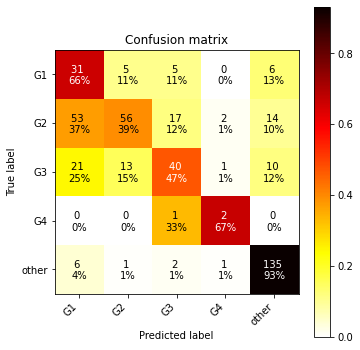

Val epoch 169
loss_G 1.485	
Accuracy:  0.59375
Accuracy: 0.59375


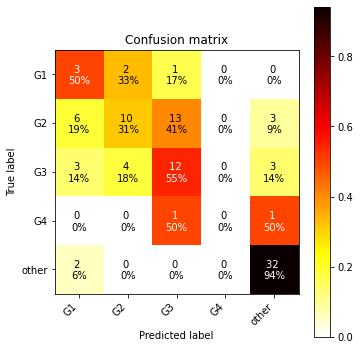

End of epoch 169 / 100 	 Time Taken: 118 sec
Train epoch 170
loss_G 0.799	
loss_G 0.626	
loss_G 0.57	
loss_G 0.597	
loss_G 0.629	
loss_G 0.654	
loss_G 0.657	
loss_G 0.667	
loss_G 0.702	
loss_G 0.735	
loss_G 0.72	
Accuracy: 0.6066350710900474


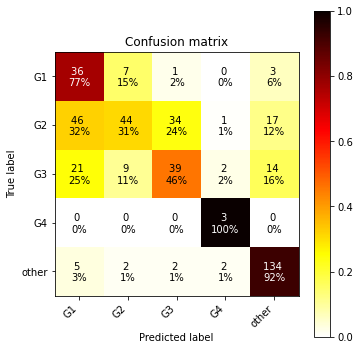

Val epoch 170
loss_G 1.298	
Accuracy:  0.5
Accuracy: 0.5


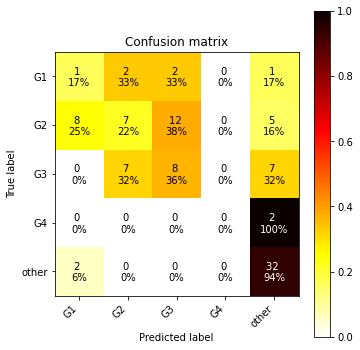

Saved model to ./models/1_grade_classification_in_NLST/170_..._.pt
End of epoch 170 / 100 	 Time Taken: 121 sec
Train epoch 171
loss_G 0.871	
loss_G 0.728	
loss_G 0.638	
loss_G 0.642	
loss_G 0.703	
loss_G 0.671	
loss_G 0.687	
loss_G 0.683	
loss_G 0.736	
loss_G 0.728	
loss_G 0.727	
Accuracy: 0.6303317535545023


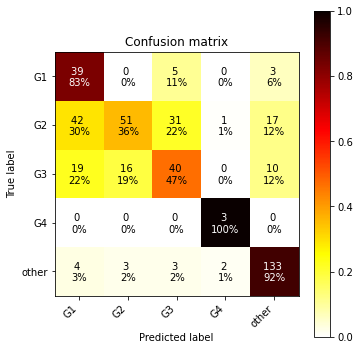

Val epoch 171
loss_G 1.243	
Accuracy:  0.5625
Accuracy: 0.5625


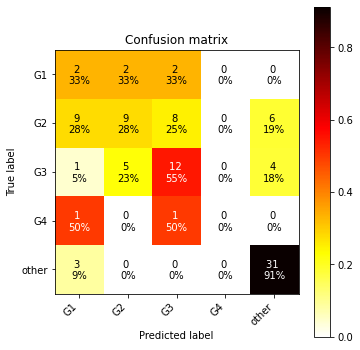

End of epoch 171 / 100 	 Time Taken: 118 sec
Train epoch 172
loss_G 0.562	
loss_G 0.57	
loss_G 0.554	
loss_G 0.542	
loss_G 0.566	
loss_G 0.595	
loss_G 0.651	
loss_G 0.666	
loss_G 0.667	
loss_G 0.672	
loss_G 0.666	
Accuracy: 0.6800947867298578


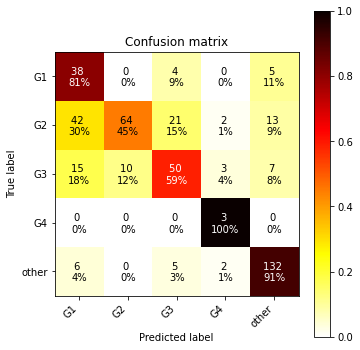

Val epoch 172
loss_G 1.399	
Accuracy:  0.53125
Accuracy: 0.53125


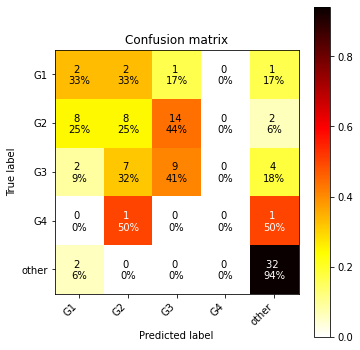

End of epoch 172 / 100 	 Time Taken: 131 sec
Train epoch 173
loss_G 0.77	
loss_G 0.749	
loss_G 0.654	
loss_G 0.61	
loss_G 0.639	
loss_G 0.653	
loss_G 0.702	
loss_G 0.673	
loss_G 0.677	
loss_G 0.66	
loss_G 0.698	
Accuracy: 0.6635071090047393


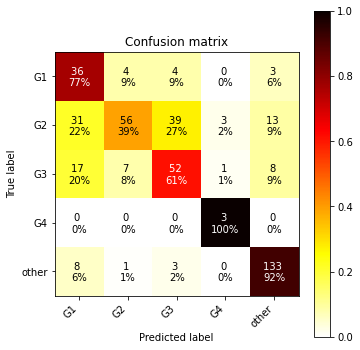

Val epoch 173
loss_G 1.279	
Accuracy:  0.6041666666666666
Accuracy: 0.6041666666666666


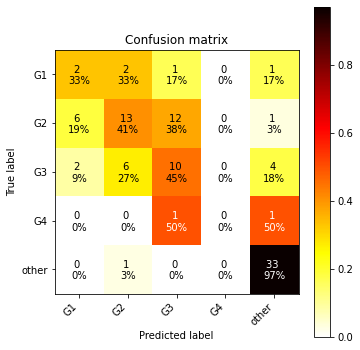

End of epoch 173 / 100 	 Time Taken: 133 sec
Train epoch 174
loss_G 0.735	
loss_G 0.669	
loss_G 0.67	
loss_G 0.703	
loss_G 0.746	
loss_G 0.731	
loss_G 0.77	
loss_G 0.757	
loss_G 0.758	
loss_G 0.773	
loss_G 0.799	
Accuracy: 0.6255924170616114


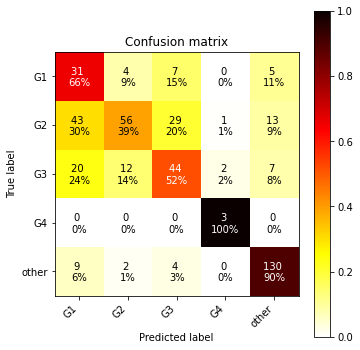

Val epoch 174
loss_G 1.26	
Accuracy:  0.6145833333333334
Accuracy: 0.6145833333333334


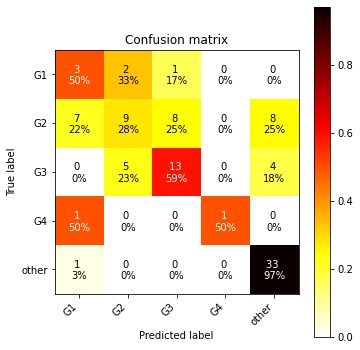

End of epoch 174 / 100 	 Time Taken: 128 sec
Train epoch 175
loss_G 0.768	
loss_G 0.772	
loss_G 0.945	
loss_G 0.991	
loss_G 0.901	
loss_G 0.839	
loss_G 0.841	
loss_G 0.836	
loss_G 0.813	
loss_G 0.818	
loss_G 0.832	
Accuracy: 0.6279620853080569


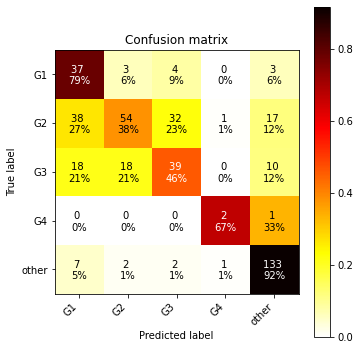

Val epoch 175
loss_G 1.299	
Accuracy:  0.6145833333333334
Accuracy: 0.6145833333333334


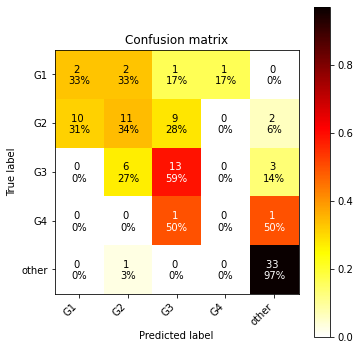

Saved model to ./models/1_grade_classification_in_NLST/175_..._.pt
End of epoch 175 / 100 	 Time Taken: 128 sec
Train epoch 176
loss_G 0.824	
loss_G 0.748	
loss_G 0.771	
loss_G 0.743	
loss_G 0.721	
loss_G 0.74	
loss_G 0.76	
loss_G 0.735	
loss_G 0.74	
loss_G 0.729	
loss_G 0.756	
Accuracy: 0.6469194312796208


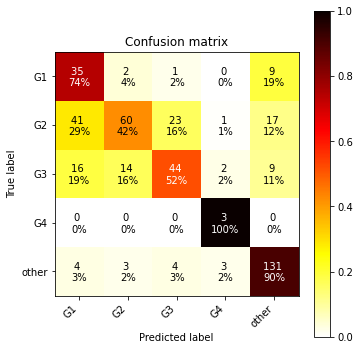

Val epoch 176
loss_G 1.497	
Accuracy:  0.59375
Accuracy: 0.59375


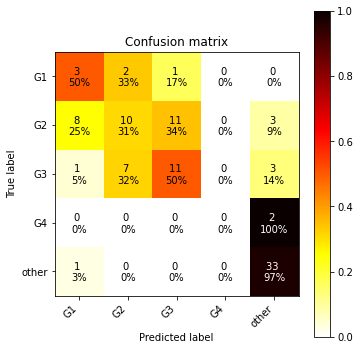

End of epoch 176 / 100 	 Time Taken: 120 sec
Train epoch 177
loss_G 0.793	
loss_G 0.779	
loss_G 0.764	
loss_G 0.911	
loss_G 0.87	
loss_G 0.827	
loss_G 0.841	
loss_G 0.883	
loss_G 0.864	
loss_G 0.845	
loss_G 0.846	
Accuracy: 0.6184834123222749


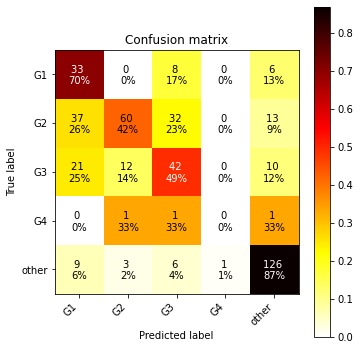

Val epoch 177
loss_G 1.411	
Accuracy:  0.5625
Accuracy: 0.5625


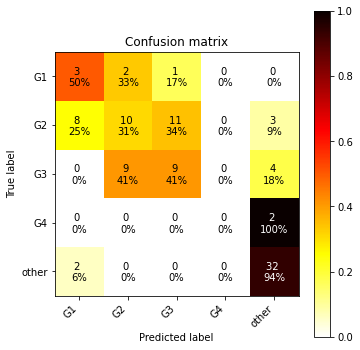

End of epoch 177 / 100 	 Time Taken: 118 sec
Train epoch 178
loss_G 0.563	
loss_G 0.643	
loss_G 0.722	
loss_G 0.737	
loss_G 0.711	
loss_G 0.715	
loss_G 0.709	
loss_G 0.706	
loss_G 0.698	
loss_G 0.696	
loss_G 0.691	
Accuracy: 0.6516587677725119


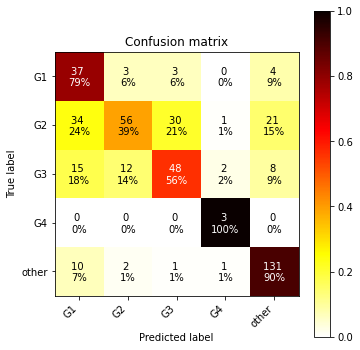

Val epoch 178
loss_G 1.305	
Accuracy:  0.5625
Accuracy: 0.5625


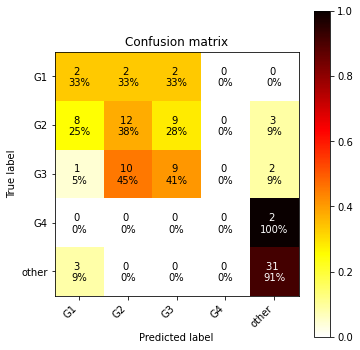

End of epoch 178 / 100 	 Time Taken: 118 sec
Train epoch 179
loss_G 0.662	
loss_G 0.818	
loss_G 0.746	
loss_G 0.729	
loss_G 0.77	
loss_G 0.774	
loss_G 0.775	
loss_G 0.738	
loss_G 0.751	
loss_G 0.775	
loss_G 0.753	
Accuracy: 0.6161137440758294


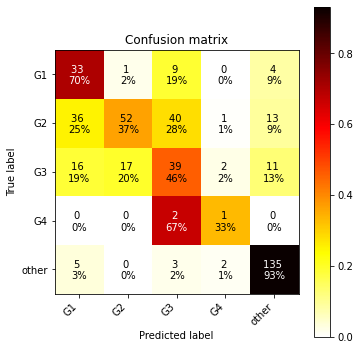

Val epoch 179
loss_G 1.206	
Accuracy:  0.5625
Accuracy: 0.5625


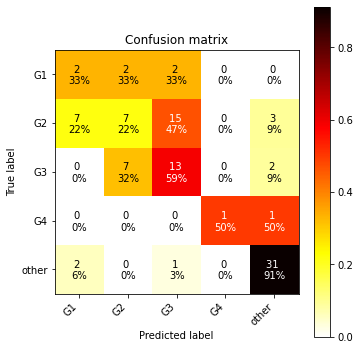

End of epoch 179 / 100 	 Time Taken: 113 sec
Train epoch 180
loss_G 0.744	
loss_G 0.682	
loss_G 0.67	
loss_G 0.661	
loss_G 0.608	
loss_G 0.638	
loss_G 0.646	
loss_G 0.643	
loss_G 0.618	
loss_G 0.645	
loss_G 0.661	
Accuracy: 0.6540284360189573


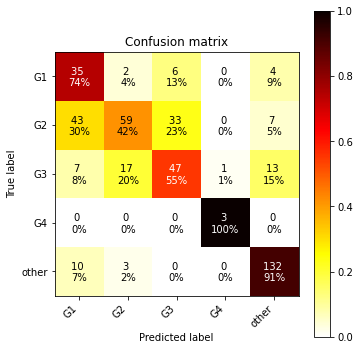

Val epoch 180
loss_G 1.572	
Accuracy:  0.5
Accuracy: 0.5


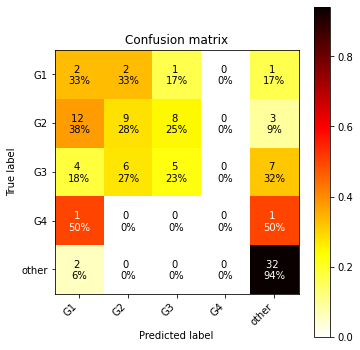

Saved model to ./models/1_grade_classification_in_NLST/180_..._.pt
End of epoch 180 / 100 	 Time Taken: 118 sec
Train epoch 181
loss_G 0.628	
loss_G 0.797	
loss_G 0.701	
loss_G 0.763	
loss_G 0.742	
loss_G 0.717	
loss_G 0.76	
loss_G 0.764	
loss_G 0.766	
loss_G 0.755	
loss_G 0.784	
Accuracy: 0.6161137440758294


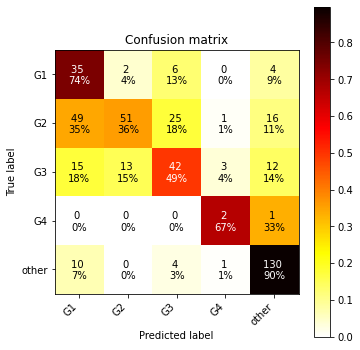

Val epoch 181
loss_G 1.482	
Accuracy:  0.53125
Accuracy: 0.53125


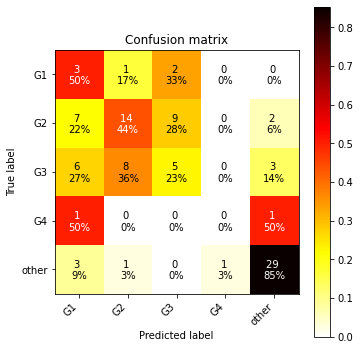

End of epoch 181 / 100 	 Time Taken: 118 sec
Train epoch 182
loss_G 0.595	
loss_G 0.598	
loss_G 0.677	
loss_G 0.666	
loss_G 0.685	
loss_G 0.686	
loss_G 0.679	
loss_G 0.673	
loss_G 0.664	
loss_G 0.684	
loss_G 0.728	
Accuracy: 0.6255924170616114


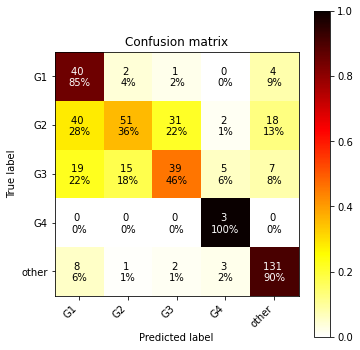

Val epoch 182
loss_G 1.468	
Accuracy:  0.5
Accuracy: 0.5


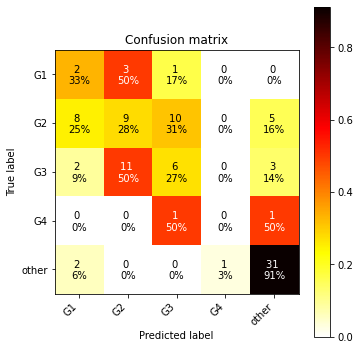

End of epoch 182 / 100 	 Time Taken: 131 sec
Train epoch 183
loss_G 0.383	
loss_G 0.45	
loss_G 0.49	
loss_G 0.554	
loss_G 0.649	
loss_G 0.67	
loss_G 0.708	
loss_G 0.719	
loss_G 0.73	
loss_G 0.72	
loss_G 0.726	
Accuracy: 0.6232227488151659


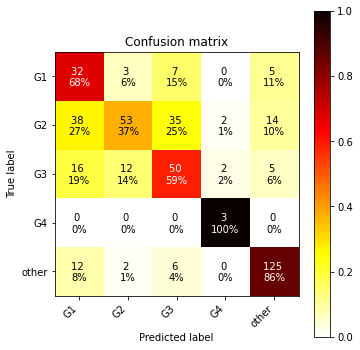

Val epoch 183
loss_G 1.563	
Accuracy:  0.5
Accuracy: 0.5


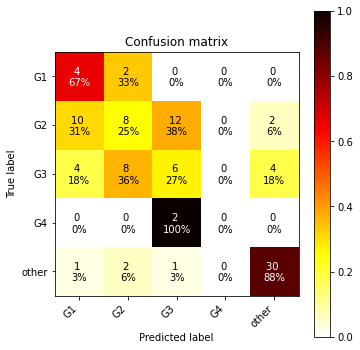

End of epoch 183 / 100 	 Time Taken: 132 sec
Train epoch 184
loss_G 0.721	
loss_G 0.682	
loss_G 0.655	
loss_G 0.618	
loss_G 0.63	
loss_G 0.657	
loss_G 0.685	
loss_G 0.663	
loss_G 0.654	
loss_G 0.683	
loss_G 0.657	
Accuracy: 0.6492890995260664


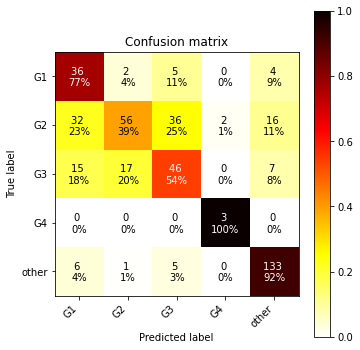

Val epoch 184
loss_G 1.733	
Accuracy:  0.5208333333333334
Accuracy: 0.5208333333333334


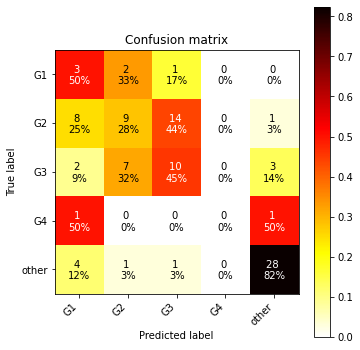

End of epoch 184 / 100 	 Time Taken: 133 sec
Train epoch 185
loss_G 0.632	
loss_G 0.65	
loss_G 0.709	
loss_G 0.828	
loss_G 0.767	
loss_G 0.781	
loss_G 0.774	
loss_G 0.776	
loss_G 0.764	
loss_G 0.761	
loss_G 0.827	
Accuracy: 0.6587677725118484


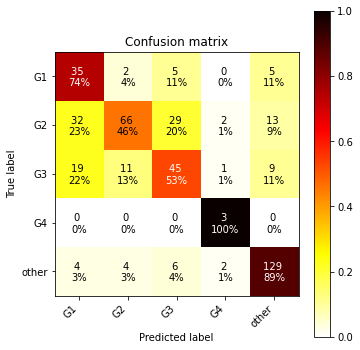

Val epoch 185
loss_G 1.445	
Accuracy:  0.5729166666666666
Accuracy: 0.5729166666666666


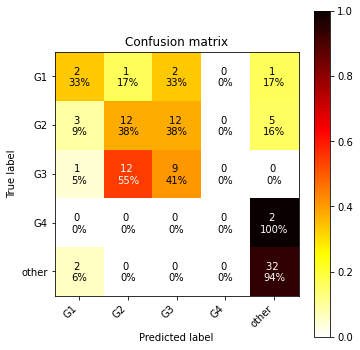

Saved model to ./models/1_grade_classification_in_NLST/185_..._.pt
End of epoch 185 / 100 	 Time Taken: 128 sec
Train epoch 186
loss_G 0.722	
loss_G 0.8	
loss_G 0.808	
loss_G 0.798	
loss_G 0.805	
loss_G 0.758	
loss_G 0.735	
loss_G 0.716	
loss_G 0.697	
loss_G 0.674	
loss_G 0.698	
Accuracy: 0.6516587677725119


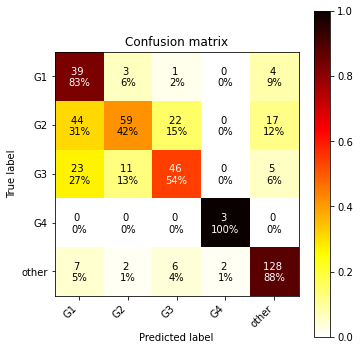

Val epoch 186
loss_G 1.315	
Accuracy:  0.5833333333333334
Accuracy: 0.5833333333333334


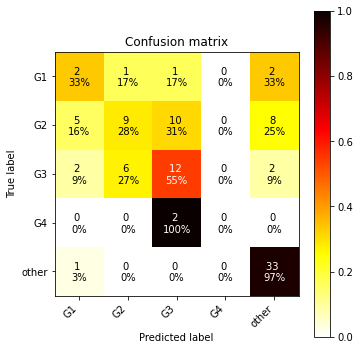

End of epoch 186 / 100 	 Time Taken: 120 sec
Train epoch 187
loss_G 0.792	
loss_G 0.719	
loss_G 0.701	
loss_G 0.779	
loss_G 0.749	
loss_G 0.771	
loss_G 0.743	
loss_G 0.733	
loss_G 0.713	
loss_G 0.741	
loss_G 0.773	
Accuracy: 0.6374407582938388


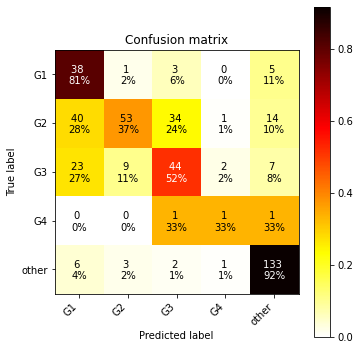

Val epoch 187
loss_G 1.367	
Accuracy:  0.46875
Accuracy: 0.46875


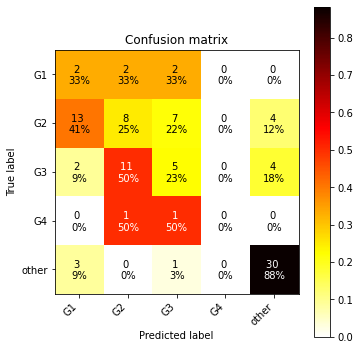

End of epoch 187 / 100 	 Time Taken: 121 sec
Train epoch 188
loss_G 0.515	
loss_G 0.7	
loss_G 0.733	
loss_G 0.726	
loss_G 0.74	
loss_G 0.704	
loss_G 0.705	
loss_G 0.728	
loss_G 0.724	
loss_G 0.717	
loss_G 0.774	
Accuracy: 0.6469194312796208


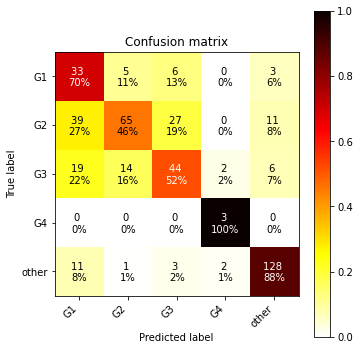

Val epoch 188
loss_G 1.518	
Accuracy:  0.53125
Accuracy: 0.53125


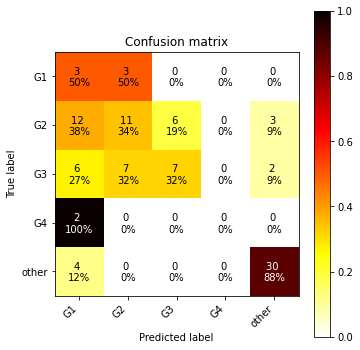

End of epoch 188 / 100 	 Time Taken: 123 sec
Train epoch 189
loss_G 1.062	
loss_G 0.925	
loss_G 0.821	
loss_G 0.819	
loss_G 0.782	
loss_G 0.784	
loss_G 0.76	
loss_G 0.752	
loss_G 0.76	
loss_G 0.747	
loss_G 0.773	
Accuracy: 0.6374407582938388


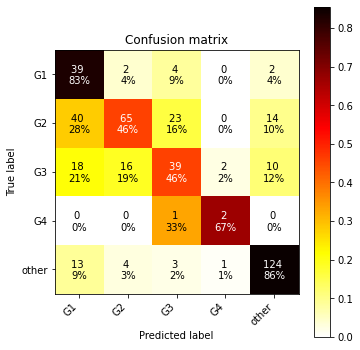

Val epoch 189
loss_G 1.587	
Accuracy:  0.5416666666666666
Accuracy: 0.5416666666666666


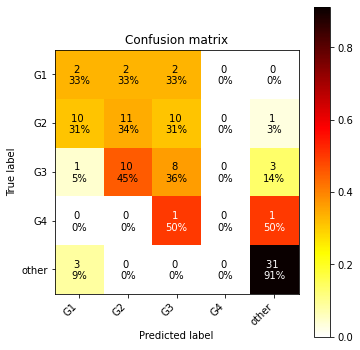

End of epoch 189 / 100 	 Time Taken: 139 sec
Train epoch 190
loss_G 0.8	
loss_G 0.726	
loss_G 0.671	
loss_G 0.786	
loss_G 0.816	
loss_G 0.756	
loss_G 0.765	
loss_G 0.774	
loss_G 0.764	
loss_G 0.762	
loss_G 0.774	
Accuracy: 0.6232227488151659


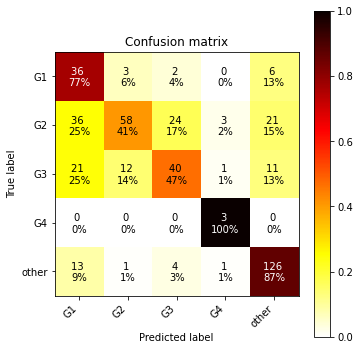

Val epoch 190
loss_G 1.456	
Accuracy:  0.5729166666666666
Accuracy: 0.5729166666666666


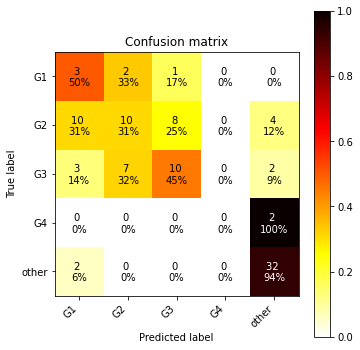

Saved model to ./models/1_grade_classification_in_NLST/190_..._.pt
End of epoch 190 / 100 	 Time Taken: 139 sec
Train epoch 191
loss_G 0.59	
loss_G 0.679	
loss_G 0.656	
loss_G 0.721	
loss_G 0.707	
loss_G 0.684	
loss_G 0.7	
loss_G 0.692	
loss_G 0.71	
loss_G 0.714	
loss_G 0.785	
Accuracy: 0.6516587677725119


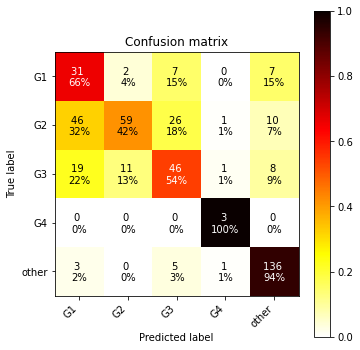

Val epoch 191
loss_G 1.485	
Accuracy:  0.5729166666666666
Accuracy: 0.5729166666666666


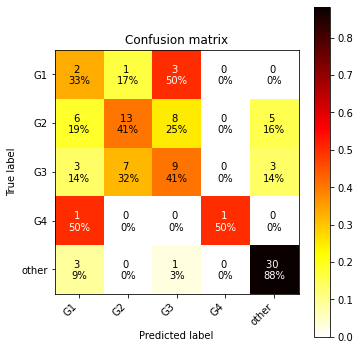

End of epoch 191 / 100 	 Time Taken: 139 sec
Train epoch 192
loss_G 0.63	
loss_G 0.623	
loss_G 0.622	
loss_G 0.629	
loss_G 0.648	
loss_G 0.646	
loss_G 0.646	
loss_G 0.645	
loss_G 0.641	
loss_G 0.66	
loss_G 0.694	
Accuracy: 0.6469194312796208


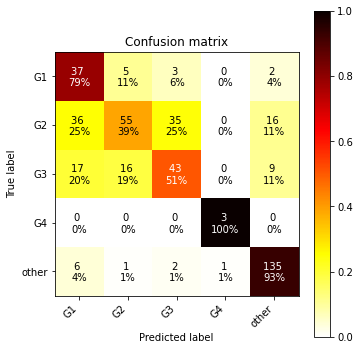

Val epoch 192
loss_G 1.476	
Accuracy:  0.5208333333333334
Accuracy: 0.5208333333333334


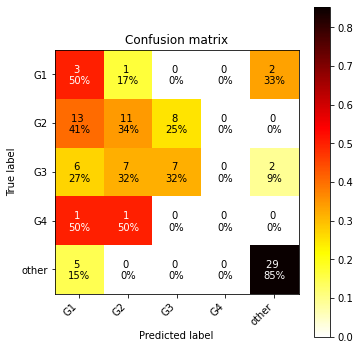

End of epoch 192 / 100 	 Time Taken: 142 sec
Train epoch 193
loss_G 0.389	
loss_G 0.509	
loss_G 0.63	
loss_G 0.639	
loss_G 0.633	
loss_G 0.657	
loss_G 0.654	
loss_G 0.657	
loss_G 0.664	
loss_G 0.673	
loss_G 0.672	
Accuracy: 0.6658767772511849


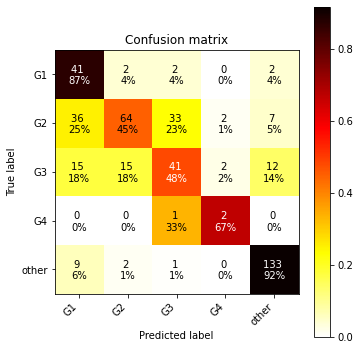

Val epoch 193
loss_G 1.195	
Accuracy:  0.53125
Accuracy: 0.53125


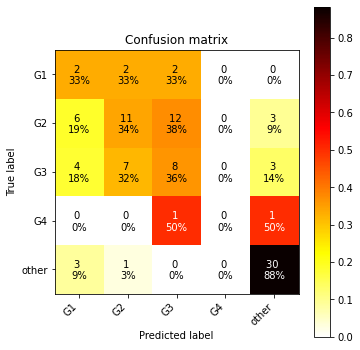

End of epoch 193 / 100 	 Time Taken: 139 sec
Train epoch 194
loss_G 0.62	
loss_G 0.544	
loss_G 0.578	
loss_G 0.629	
loss_G 0.647	
loss_G 0.686	
loss_G 0.706	
loss_G 0.701	
loss_G 0.694	
loss_G 0.695	
loss_G 0.677	
Accuracy: 0.6682464454976303


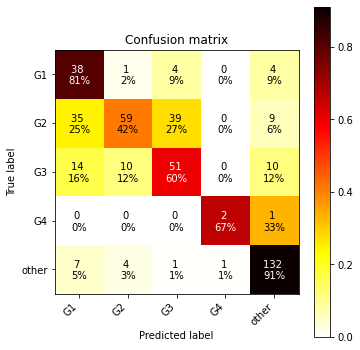

Val epoch 194
loss_G 1.52	
Accuracy:  0.5
Accuracy: 0.5


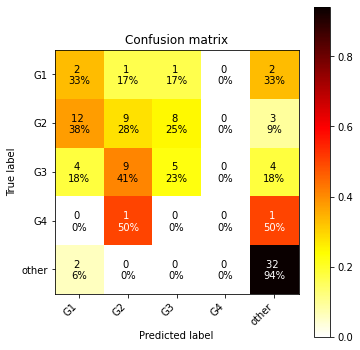

End of epoch 194 / 100 	 Time Taken: 137 sec
Train epoch 195
loss_G 1.237	
loss_G 0.942	
loss_G 0.851	
loss_G 0.811	
loss_G 0.865	
loss_G 0.841	
loss_G 0.82	
loss_G 0.812	
loss_G 0.809	
loss_G 0.773	
loss_G 0.758	
Accuracy: 0.6445497630331753


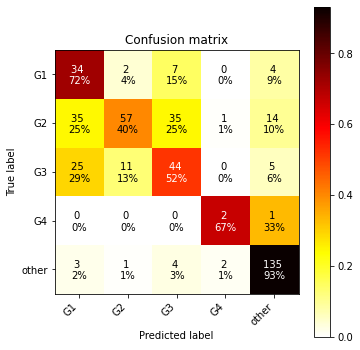

Val epoch 195
loss_G 1.414	
Accuracy:  0.5416666666666666
Accuracy: 0.5416666666666666


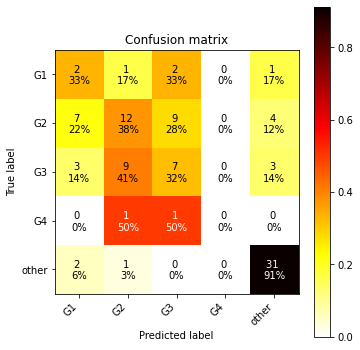

Saved model to ./models/1_grade_classification_in_NLST/195_..._.pt
End of epoch 195 / 100 	 Time Taken: 137 sec
Train epoch 196
loss_G 0.506	
loss_G 0.653	
loss_G 0.66	
loss_G 0.698	
loss_G 0.703	
loss_G 0.775	
loss_G 0.729	
loss_G 0.728	
loss_G 0.741	
loss_G 0.749	
loss_G 0.766	
Accuracy: 0.6398104265402843


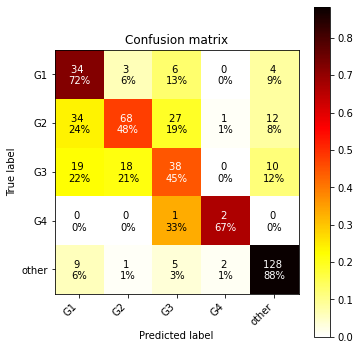

Val epoch 196
loss_G 1.222	
Accuracy:  0.59375
Accuracy: 0.59375


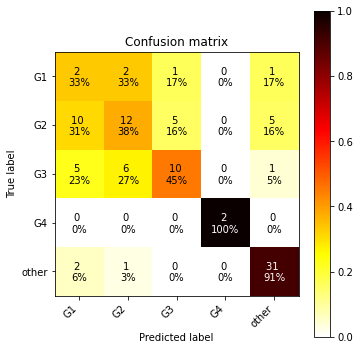

End of epoch 196 / 100 	 Time Taken: 133 sec
Train epoch 197
loss_G 0.97	
loss_G 0.856	
loss_G 0.713	
loss_G 0.725	
loss_G 0.681	
loss_G 0.684	
loss_G 0.666	
loss_G 0.685	
loss_G 0.708	
loss_G 0.733	
loss_G 0.741	
Accuracy: 0.6469194312796208


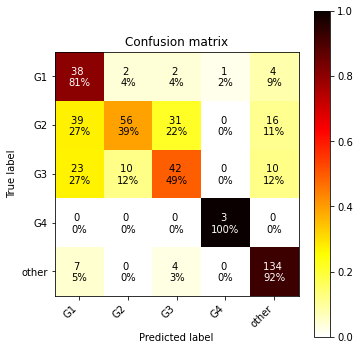

Val epoch 197
loss_G 1.416	
Accuracy:  0.5520833333333334
Accuracy: 0.5520833333333334


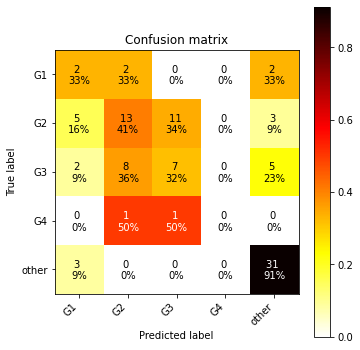

End of epoch 197 / 100 	 Time Taken: 135 sec
Train epoch 198
loss_G 0.771	
loss_G 0.713	
loss_G 0.699	
loss_G 0.653	
loss_G 0.66	
loss_G 0.731	
loss_G 0.772	
loss_G 0.782	
loss_G 0.782	
loss_G 0.794	
loss_G 0.813	
Accuracy: 0.6113744075829384


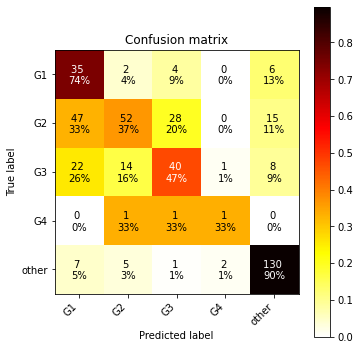

Val epoch 198
loss_G 1.104	
Accuracy:  0.5416666666666666
Accuracy: 0.5416666666666666


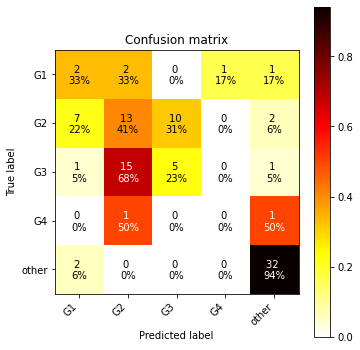

End of epoch 198 / 100 	 Time Taken: 141 sec
Train epoch 199
loss_G 0.85	
loss_G 0.67	
loss_G 0.751	
loss_G 0.726	
loss_G 0.682	
loss_G 0.666	
loss_G 0.649	
loss_G 0.668	
loss_G 0.661	
loss_G 0.664	
loss_G 0.687	
Accuracy: 0.6516587677725119


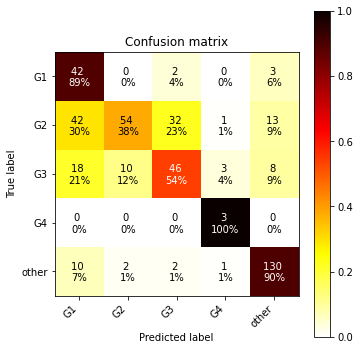

Val epoch 199
loss_G 1.269	
Accuracy:  0.5833333333333334
Accuracy: 0.5833333333333334


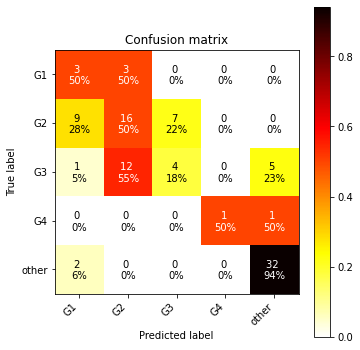

End of epoch 199 / 100 	 Time Taken: 136 sec


In [156]:
import time

save_freq = 5
best_loss_val = 10000

for epoch in range(100, 200): 
    epoch_start_time = time.time()
    
    global YS
    global PREDS
    YS = []
    PREDS = []
    hist_epoch = train(classification_model_weight, train_loader, epoch, loss_names, print_freq=2)
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name] == []:
                hist[loss_name] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name].append(hist_epoch[loss_name])
    from sklearn.metrics import confusion_matrix
    plt.figure(figsize=(5, 5))
    plot_confusion_matrix_combine(confusion_matrix(YS, PREDS), CLASSES_NAMES,
                                 stain_norm=True, cmap=plt.cm.hot_r)
    
    hist_epoch = val(classification_model_weight, val_loader, epoch, loss_names)
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name+"_val"] == []:
                hist[loss_name+"_val"] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name+"_val"][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name+"_val"][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name+"_val"].append(hist_epoch[loss_name])
    
    # Save model
    if epoch % save_freq == 0:
        classification_model_weight.save_networks(epoch)
        print("Saved model to {}".format(os.path.join(model_dir, str(epoch)+"_..._.pt")))
    if hist["loss_G_val"][-1] < best_loss_val:
        classification_model_weight.save_networks("best")
        print("Saved best model to {}".format(os.path.join(model_dir, "best_..._.pt")))
        best_loss_val = hist["loss_G_val"][-1]
        
    # classification_model_weight.update_learning_rate()

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, 
           classification_model_weight.n_epochs + classification_model_weight.n_epochs_decay, 
           time.time() - epoch_start_time))

In [157]:
torch.save(hist, os.path.join(model_dir, "hist.pt"))

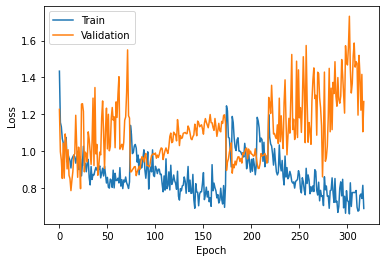

In [158]:
plt.plot(hist['loss_G'], label="Train")
plt.plot(hist['loss_G_val'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [115]:
epoch_load = 110

classification_model_weight.load_networks(epoch_load)
hist = torch.load(os.path.join(model_dir, "hist.pt"))
loss_names = ["loss_G"]

for loss_name in loss_names:
    if isinstance(hist[loss_name], dict):
        for key in list(hist_epoch[loss_name].keys()):
            hist[loss_name][key] = hist[loss_name][key][:(epoch_load + 1)]
    else:
        hist[loss_name] = hist[loss_name][:(epoch_load + 1)]
        
    if isinstance(hist[loss_name+'_val'], dict):
        for key in list(hist_epoch[loss_name+'_val'].keys()):
            hist[loss_name+'_val'][key] = hist[loss_name+'_val'][key][:(epoch_load + 1)]
    else:
        hist[loss_name+'_val'] = hist[loss_name+'_val'][:(epoch_load + 1)]
        
import time

save_freq = 5
best_loss_val = 10000

for epoch in range(epoch_load + 1, 200): 
    epoch_start_time = time.time()
    
    hist_epoch = train(classification_model_weight, train_loader, epoch, loss_names, print_freq=2)
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name] == []:
                hist[loss_name] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name].append(hist_epoch[loss_name])
    
    hist_epoch = val(classification_model_weight, data_val, epoch, loss_names)  # Use fixed patches
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name+"_val"] == []:
                hist[loss_name+"_val"] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name+"_val"][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name+"_val"][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name+"_val"].append(hist_epoch[loss_name])
    
    # Save model
    if epoch % save_freq == 0:
        classification_model_weight.save_networks(epoch)
        print("Saved model to {}".format(os.path.join(model_dir, str(epoch)+"_..._.pt")))
    if hist["loss_G_val"][-1] < best_loss_val:
        classification_model.save_networks("best_weighted_")
        print("Saved best model to {}".format(os.path.join(model_dir, "best_..._.pt")))
        best_loss_val = hist["loss_G_val"][-1]
        
    classification_model_weight.update_learning_rate()

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, 200, time.time() - epoch_start_time))

loading the model from ./models/1_grade_classification_in_NLST/110_net_G.pth
Train epoch 111
loss_G 0.715	
loss_G 0.971	
loss_G 0.955	
loss_G 0.958	
loss_G 0.959	
loss_G 0.952	
loss_G 0.932	
loss_G 0.943	
loss_G 0.932	
loss_G 0.948	
loss_G 0.913	
Val epoch 111
loss_G 0.932	
Accuracy:  0.6152777777777778
Saved best model to ./models/1_grade_classification_in_NLST/best_..._.pt
learning rate 0.0000100 -> 0.0000100
End of epoch 111 / 200 	 Time Taken: 156 sec
Train epoch 112
loss_G 1.055	
loss_G 0.977	
loss_G 0.947	
loss_G 1.028	
loss_G 1.078	
loss_G 1.048	
loss_G 1.026	
loss_G 1.012	
loss_G 1.008	
loss_G 1.006	
loss_G 0.993	
Val epoch 112
loss_G 0.986	
Accuracy:  0.5986111111111111
learning rate 0.0000100 -> 0.0000100
End of epoch 112 / 200 	 Time Taken: 160 sec
Train epoch 113
loss_G 0.89	
loss_G 0.863	
loss_G 0.861	
loss_G 0.882	
loss_G 0.878	
loss_G 0.888	
loss_G 0.889	
loss_G 0.887	
loss_G 0.912	
loss_G 0.922	
loss_G 0.946	
Val epoch 113
loss_G 1.019	
Accuracy:  0.5902777777777778
lea

KeyboardInterrupt: 

In [28]:
classification_model_weight.save_networks(epoch)
print("Saved model to {}".format(os.path.join(model_dir, str(epoch)+"_..._.pt")))
torch.save(hist, os.path.join(model_dir, "hist.pt"))

Saved model to ./models/1_grade_classification_in_NLST/199_..._.pt


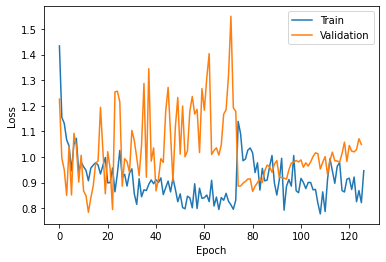

In [116]:
plt.plot(hist['loss_G'], label="Train")
plt.plot(hist['loss_G_val'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [40]:
classification_model_weight = ClassificationModelWeighted(device=device_2, save_dir=model_dir, 
                                                          n_epochs=100, lr=0.00001, 
                                          n_classes=N_CLASSES)
weight = torch.tensor([3, 0.5, 0.9, 10, 1])
classification_model_weight.set_loss_weight(weight=weight)
classification_model_weight.load_networks(199)
hist = torch.load(os.path.join(model_dir, "hist.pt"))
loss_names = ["loss_G"]

for loss_name in loss_names:
    if isinstance(hist[loss_name], dict):
        for key in list(hist_epoch[loss_name].keys()):
            hist[loss_name][key] = hist[loss_name][key][:200]
    else:
        hist[loss_name] = hist[loss_name][:200]
        
    if isinstance(hist[loss_name+'_val'], dict):
        for key in list(hist_epoch[loss_name+'_val'].keys()):
            hist[loss_name+'_val'][key] = hist[loss_name+'_val'][key][:200]
    else:
        hist[loss_name+'_val'] = hist[loss_name+'_val'][:200]

for epoch in range(200, 300): 
    epoch_start_time = time.time()
    
    hist_epoch = train(classification_model_weight, train_loader, epoch, loss_names, print_freq=2)
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name] == []:
                hist[loss_name] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name].append(hist_epoch[loss_name])
    
    hist_epoch = val(classification_model_weight, data_val, epoch, loss_names)  # Use fixed patches
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name+"_val"] == []:
                hist[loss_name+"_val"] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name+"_val"][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name+"_val"][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name+"_val"].append(hist_epoch[loss_name])
    
    # Save model
    if epoch % save_freq == 0:
        classification_model_weight.save_networks(epoch)
        print("Saved model to {}".format(os.path.join(model_dir, str(epoch)+"_..._.pt")))
        
    # classification_model_weight.update_learning_rate()

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, 200, time.time() - epoch_start_time))

loading the model from ./models/1_grade_classification_in_NLST/199_net_G.pth
Train epoch 200
loss_G 0.399	
loss_G 0.437	
loss_G 0.402	
loss_G 0.411	
loss_G 0.49	
loss_G 0.496	
loss_G 0.497	
Val epoch 200
loss_G 1.168	
Accuracy:  0.5505050505050505
Saved model to ./models/1_grade_classification_in_NLST/200_..._.pt
End of epoch 200 / 200 	 Time Taken: 99 sec
Train epoch 201
loss_G 0.489	
loss_G 0.583	
loss_G 0.502	
loss_G 0.534	
loss_G 0.537	
loss_G 0.548	
loss_G 0.549	
Val epoch 201
loss_G 1.189	
Accuracy:  0.5272727272727272
End of epoch 201 / 200 	 Time Taken: 93 sec
Train epoch 202
loss_G 0.786	
loss_G 0.78	
loss_G 0.714	
loss_G 0.65	
loss_G 0.599	
loss_G 0.575	
loss_G 0.568	
Val epoch 202
loss_G 1.281	
Accuracy:  0.5363636363636364
End of epoch 202 / 200 	 Time Taken: 96 sec
Train epoch 203
loss_G 0.621	
loss_G 0.605	
loss_G 0.594	
loss_G 0.547	
loss_G 0.552	
loss_G 0.664	
loss_G 0.664	
Val epoch 203
loss_G 1.283	
Accuracy:  0.5424242424242425
End of epoch 203 / 200 	 Time Taken: 92

Val epoch 235
loss_G 1.093	
Accuracy:  0.5353535353535354
Saved model to ./models/1_grade_classification_in_NLST/235_..._.pt
End of epoch 235 / 200 	 Time Taken: 77 sec
Train epoch 236
loss_G 0.413	
loss_G 0.488	
loss_G 0.618	
loss_G 0.601	
loss_G 0.65	
loss_G 0.663	
loss_G 0.633	
Val epoch 236
loss_G 1.115	
Accuracy:  0.5303030303030303
End of epoch 236 / 200 	 Time Taken: 77 sec
Train epoch 237
loss_G 0.396	
loss_G 0.531	
loss_G 0.509	
loss_G 0.555	
loss_G 0.557	
loss_G 0.54	
loss_G 0.537	
Val epoch 237
loss_G 1.202	
Accuracy:  0.5111111111111111
End of epoch 237 / 200 	 Time Taken: 77 sec
Train epoch 238
loss_G 0.402	
loss_G 0.46	
loss_G 0.574	
loss_G 0.558	
loss_G 0.559	
loss_G 0.549	
loss_G 0.552	
Val epoch 238
loss_G 1.131	
Accuracy:  0.5454545454545454
End of epoch 238 / 200 	 Time Taken: 78 sec
Train epoch 239
loss_G 0.457	
loss_G 0.586	
loss_G 0.551	
loss_G 0.539	
loss_G 0.517	
loss_G 0.56	
loss_G 0.566	
Val epoch 239
loss_G 1.109	
Accuracy:  0.5434343434343434
End of epoch 23

loss_G 0.458	
loss_G 0.485	
loss_G 0.457	
loss_G 0.507	
loss_G 0.506	
Val epoch 271
loss_G 1.186	
Accuracy:  0.5535353535353535
End of epoch 271 / 200 	 Time Taken: 64 sec
Train epoch 272
loss_G 0.844	
loss_G 0.676	
loss_G 0.7	
loss_G 0.697	
loss_G 0.65	
loss_G 0.616	
loss_G 0.595	
Val epoch 272
loss_G 1.14	
Accuracy:  0.5717171717171717
End of epoch 272 / 200 	 Time Taken: 62 sec
Train epoch 273
loss_G 0.425	
loss_G 0.423	
loss_G 0.415	
loss_G 0.403	
loss_G 0.435	
loss_G 0.561	
loss_G 0.555	
Val epoch 273
loss_G 1.196	
Accuracy:  0.5525252525252525
End of epoch 273 / 200 	 Time Taken: 63 sec
Train epoch 274
loss_G 0.435	
loss_G 0.412	
loss_G 0.4	
loss_G 0.409	
loss_G 0.409	
loss_G 0.444	
loss_G 0.462	
Val epoch 274
loss_G 1.183	
Accuracy:  0.5434343434343434
End of epoch 274 / 200 	 Time Taken: 64 sec
Train epoch 275
loss_G 0.539	
loss_G 0.487	
loss_G 0.485	
loss_G 0.499	
loss_G 0.49	
loss_G 0.46	
loss_G 0.513	
Val epoch 275
loss_G 1.174	
Accuracy:  0.5717171717171717
Saved model to .

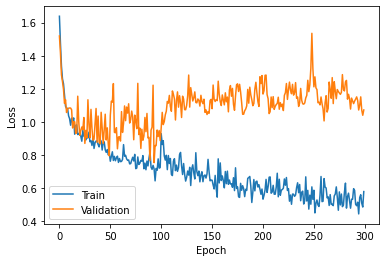

In [43]:
plt.plot(hist['loss_G'], label="Train")
plt.plot(hist['loss_G_val'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [44]:
classification_model_weight.save_networks(epoch)
print("Saved model to {}".format(os.path.join(model_dir, str(epoch)+"_..._.pt")))

Saved model to ./models/1_grade_classification_in_NLST/300_..._.pt


# 6) Test again

In [96]:
import itertools
def plot_confusion_matrix_combine(cm, classes,
                                  title='Confusion matrix',
                                  cmap=plt.cm.Blues, stain_norm=False):
    """
    This function prints and plots the confusion matrix with numbers and accuracy together.
    """
    print("Accuracy: {}".format(np.trace(cm)/np.sum(cm)))
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Remove nan
    cm_norm[np.isnan(cm_norm)] = 0
    
    if not stain_norm:
        thresh = cm.max() / 2.
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        thresh = cm_norm.max() / 2.
        plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    # fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if not stain_norm:
            plt.text(j, i+0.2, "{} \n{}%".format(format(cm[i, j], 'd'), format(cm_norm[i, j]*100, '.0f')),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i+0.2, "{} \n{}%".format(format(cm[i, j], 'd'), format(cm_norm[i, j]*100, '.0f')),
                     horizontalalignment="center",
                     color="white" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [160]:
epoch = "best"
# 40: 53%
# 45: 59%
# 50: 56%
# 5: 53%
# 95: 60%
# 99: 58%
classification_model_weight.load_networks(epoch)

loading the model from ./models/1_grade_classification_in_NLST/best_net_G.pth


In [161]:
val_patch_names = [_ for  _ in os.listdir("./data/val_patches/") if _.endswith(".png")]
print("Val epoch {}".format(epoch))
data_val = []
ys = []
preds = []
for val_patch_name in val_patch_names:
    val_patch = skimage.io.imread(os.path.join("./data/val_patches", val_patch_name))
    val_patch = normalize(val_patch)
    val_patch = torch.tensor(np.transpose(val_patch, (2, 0, 1)).astype(float))
    val_patch = val_patch.unsqueeze(0)
    y = torch.tensor(int(val_patch_name.split('.png')[0].split('_')[-1])).unsqueeze(0)
    data = [val_patch, y]
    with torch.no_grad():
        # Forward
        classification_model_weight.set_input(data)
        classification_model_weight.forward_wo_optimize_parameters()
    
    data_val.append(data)
    ys.extend(list(data[1].numpy()))
    preds.extend(list(torch.argmax(classification_model_weight.probs, 1).cpu().numpy()))
print("Accuracy: ", np.sum(np.array(ys) == np.array(preds))/len(ys))

Val epoch best
Accuracy:  0.5729166666666666


In [162]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ys, preds)
cm

array([[ 36,  27,  21,   1,   5],
       [114, 161, 171,   1,  33],
       [ 32,  79, 155,   4,  60],
       [  3,   2,   5,  11,   9],
       [ 42,   5,   1,   0, 462]])

Accuracy: 0.5729166666666666


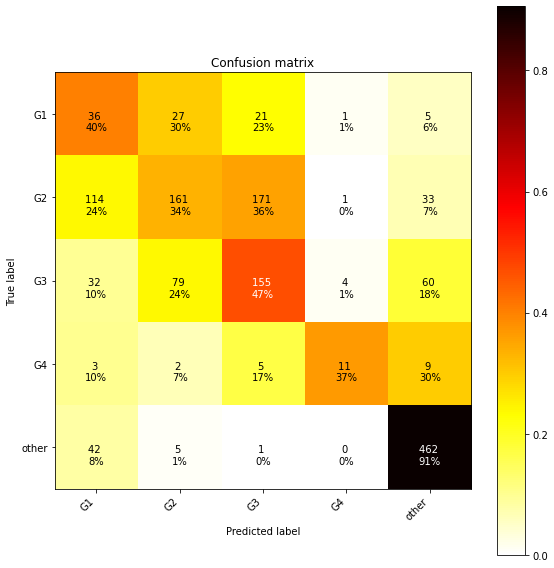

In [163]:
plt.figure(figsize=(8, 8))
plot_confusion_matrix_combine(confusion_matrix(ys, preds), CLASSES_NAMES,
                             stain_norm=True, cmap=plt.cm.hot_r)

# SessionInfo

In [260]:
! pip freeze

absl-py==0.7.0
adjustText==0.7.3
aiohttp==3.8.1
aiosignal==1.2.0
altair==3.2.0
anndata==0.7.5
argh==0.26.2
ase==3.21.1
astor==0.7.1
astropy==3.2.1
async-timeout==4.0.2
asynctest==0.13.0
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.3
autograd-gamma==0.5.0
backcall==0.1.0
base58==1.0.3
bleach==1.5.0
blinker==1.4
boto3==1.10.15
botocore==1.13.15
Bottleneck==1.2.1
cachetools==4.1.0
certifi==2021.5.30
chardet==3.0.4
charset-normalizer==2.0.4
Click==7.0
cvxopt==1.2.3
cvxpy==1.0.24
cycler==0.10.0
Cython==0.29.15
czifile==2019.7.2
dataclasses==0.8
datasets==1.17.0
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
docutils==0.15.2
ecos==2.0.7.post1
entrypoints==0.3
enum-compat==0.0.3
environment-kernels==1.1.1
fastcluster==1.2.4
filelock==3.4.1
FITS-tools==0.2
formulaic==0.2.4
frozenlist==1.2.0
fsspec==2022.1.0
future==0.17.1
gast==0.2.2
get_version==2.1
google-auth==1.14.3
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
googledrivedownloader==0.4
grpcio==1.29.0
h5py==2.10.0
html5lib==0.9999999
h